In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler

# dpi = 300
# mpl.rcParams['figure.dpi'] = dpi

custom_cycler = (cycler(color=['c', 'm', 'y', 'k']) +
                 cycler(lw=[1, 2, 3, 4]))


name: Module_EGFR_1 | forward specie(s): EGFR | backward specie(s): uEGFR | type: MichaelisMentenGeneral
name: Module_EGFR_2 | forward specie(s): EGFR | backward specie(s): pEGFR | type: MichaelisMentenGeneral

vm_EGFR_to_uEGFR,0.2
km_EGFR_to_uEGFR,100
vm_uEGFR_to_EGFR,10
km_uEGFR_to_EGFR,100
km_EGFR_to_pEGFR,100
vm_pEGFR_to_EGFR,10
km_pEGFR_to_EGFR,100
kc_EGFR_to_pEGFR_EGF,1
EGF,('EGF', 8.33, 100)

EGFR,100
uEGFR,0
pEGFR,0
EGF,0



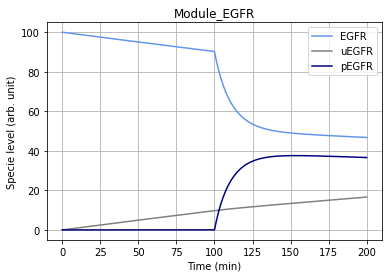

In [5]:
from src.OdeModel import OdeModel
import src.reactions as re

Module_EGFR = OdeModel('Module_EGFR')
Module_EGFR.addReaction(re.MichaelisMentenGeneral('EGFR', 'uEGFR', noBackward=True, Vmax_f=0.2))
Module_EGFR.addReaction(re.MichaelisMentenGeneral('EGFR', 'pEGFR'))
Module_EGFR.specieConc(['EGFR'], [100])
print(Module_EGFR)

Module_EGFR.addActivation('EGF', 8.33, 100)
Module_EGFR.addStimulator('Module_EGFR_2', 'EGF', kc=1)

print(Module_EGFR.getParams())
print(Module_EGFR.getStates())

Module_EGFR.simulate_beta(200)
Module_EGFR.plot(ignore_list=['EGF'], colours=['cornflowerblue', 'grey', 'navy'], savefig=True, name="mpl-31-1")

# mpl.rc("savefig", dpi=dpi)



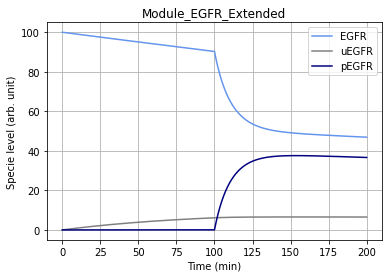

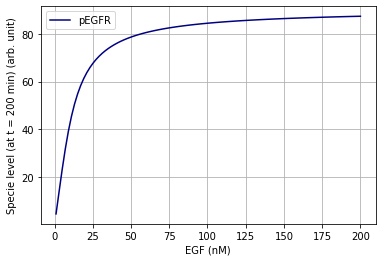

In [6]:
Module_EGFR_extended = OdeModel('Module_EGFR_Extended')
Module_EGFR_extended = Module_EGFR_extended.combine(Module_EGFR, 'Module_EGFR_Extended')
Module_EGFR_extended.addReaction(re.Synthesis('EGFR'))
Module_EGFR_extended.addReaction(re.Degradation('uEGFR'))
Module_EGFR_extended.addReaction(re.Degradation('EGFR', KDeg=0.0001))
Module_EGFR_extended.addReaction(re.Degradation('pEGFR', KDeg=0.0001))

Module_EGFR_extended.simulate_beta(200)
Module_EGFR_extended.plot(ignore_list=['EGF'], colours=['cornflowerblue', 'grey', 'navy'], savefig=True, name="mpl-31-2")

# Analysing Module_EGFR using EGF as an input
# pEGFR is treated as an output

output_list = []
output_var = 'pEGFR'
input_var = 'EGF'

p_range = np.linspace(1, 200, 100)
for p in p_range:
    Module_EGFR.addActivation('EGF', p, 100)
    Module_EGFR.simulate_beta(200)
    o = Module_EGFR.extractStateValues(output_var)[-1]
    output_list.append(o)

plt.plot(p_range, output_list, label=output_var, c='navy')
plt.legend()
plt.grid()
plt.xlabel('EGF (nM)')
plt.ylabel('Specie level (arb. unit)')

plt.savefig('mpl-31-3.png', dpi=300)
plt.show()



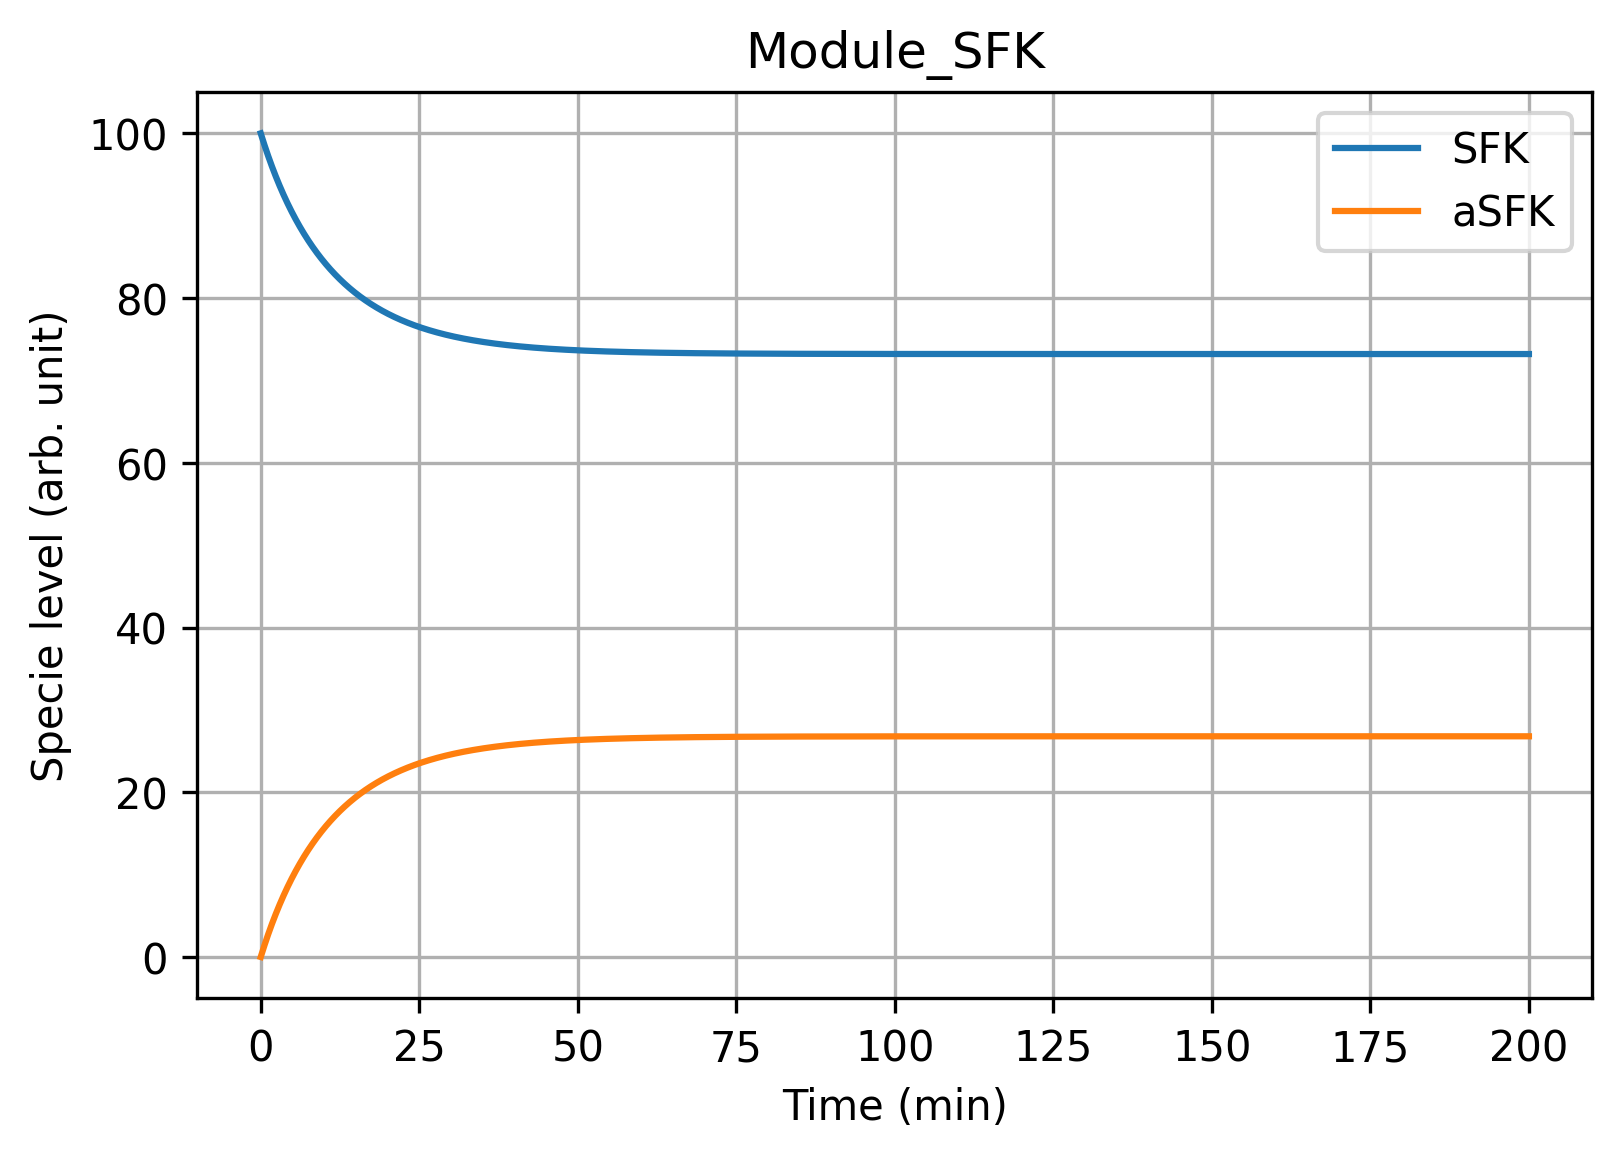

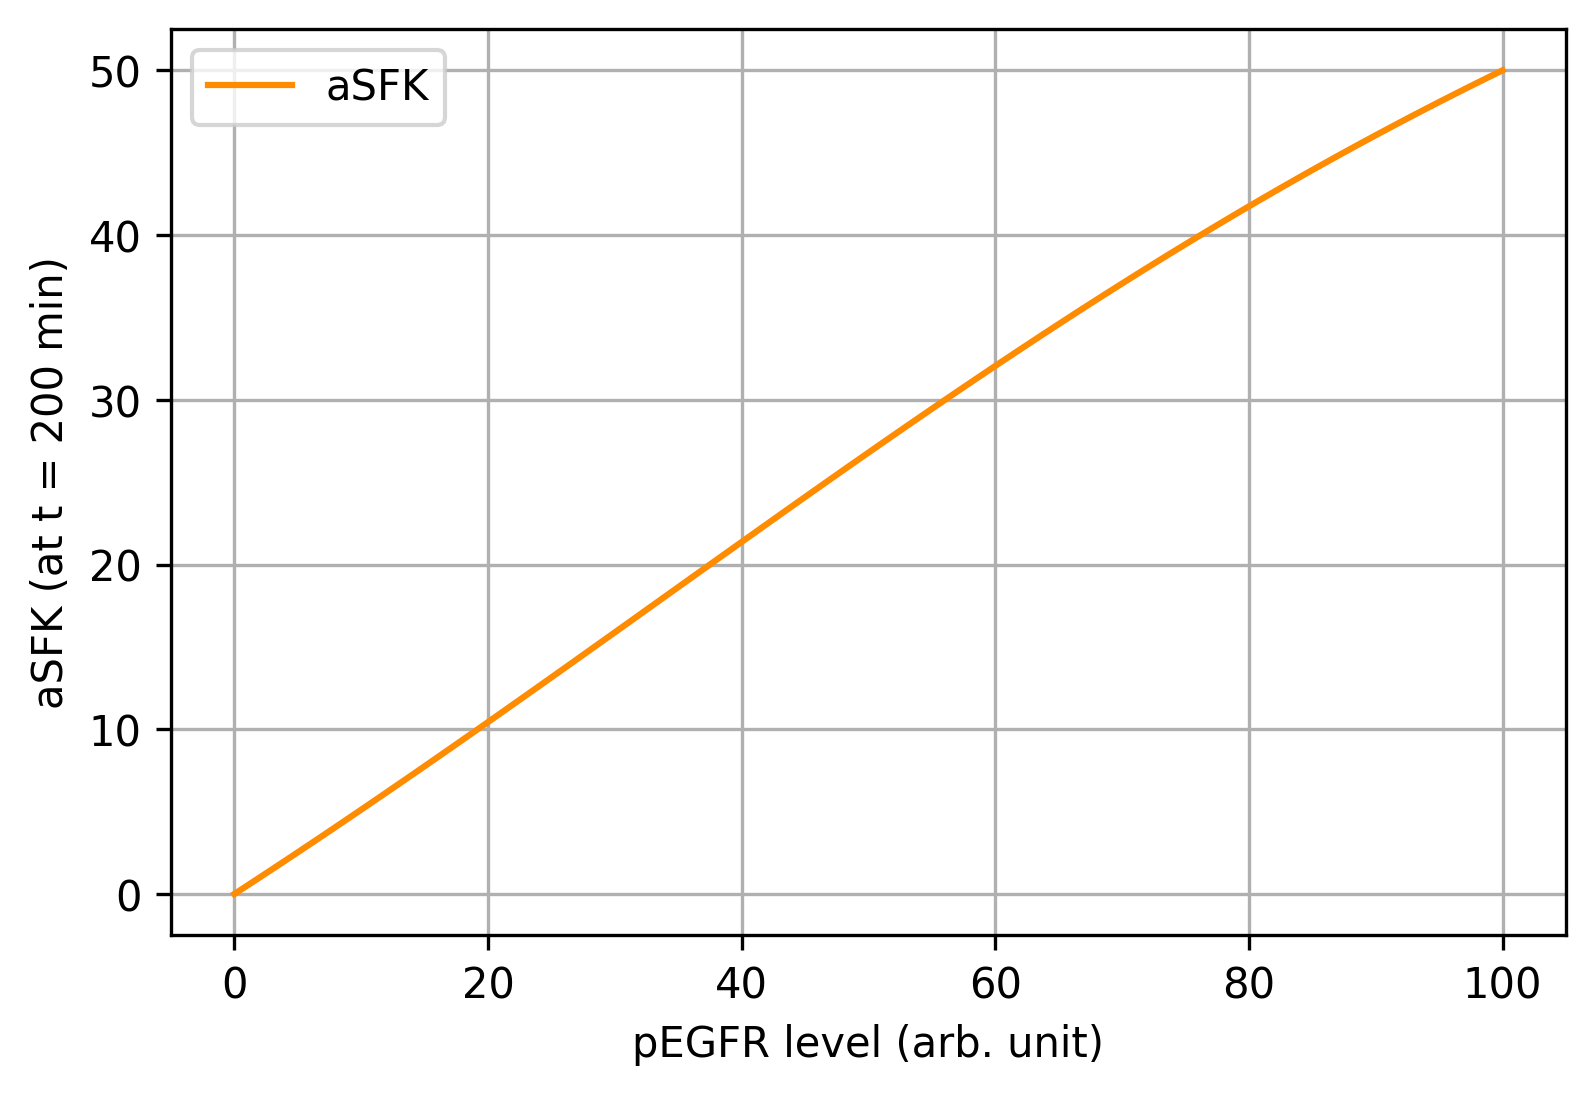

In [5]:
Module_SFK = OdeModel('Module_SFK')
Module_SFK.addReaction(re.MichaelisMentenGeneral('SFK', 'aSFK'))
Module_SFK.specieConc(['SFK'], [100])

Module_SFK.addStimulator('Module_SFK_1', "pEGFR")
Module_SFK.setState('pEGFR', 50)

Module_SFK.simulate_beta(200)
Module_SFK.plot(ignore_list=['pEGFR'], savefig=True, name="mpl-32-sfk-1")

# Input is pEGFR, output is pSFK

output_list = []
output_var = 'aSFK'
input_var = 'pEGFR'

p_range = np.linspace(0, 100, 100)
for p in p_range:
    Module_SFK.setState(input_var, p)
    Module_SFK.simulate_beta(200)
    o = Module_SFK.extractStateValues(output_var)[-1]
    output_list.append(o)

plt.plot(p_range, output_list, label=output_var, c='darkorange')
plt.legend()
plt.grid()
plt.xlabel('pEGFR level (arb. unit)')
plt.ylabel('aSFK (at t = 200 min)')
plt.savefig('mpl-32-sfk-2', dpi=300)
plt.show()



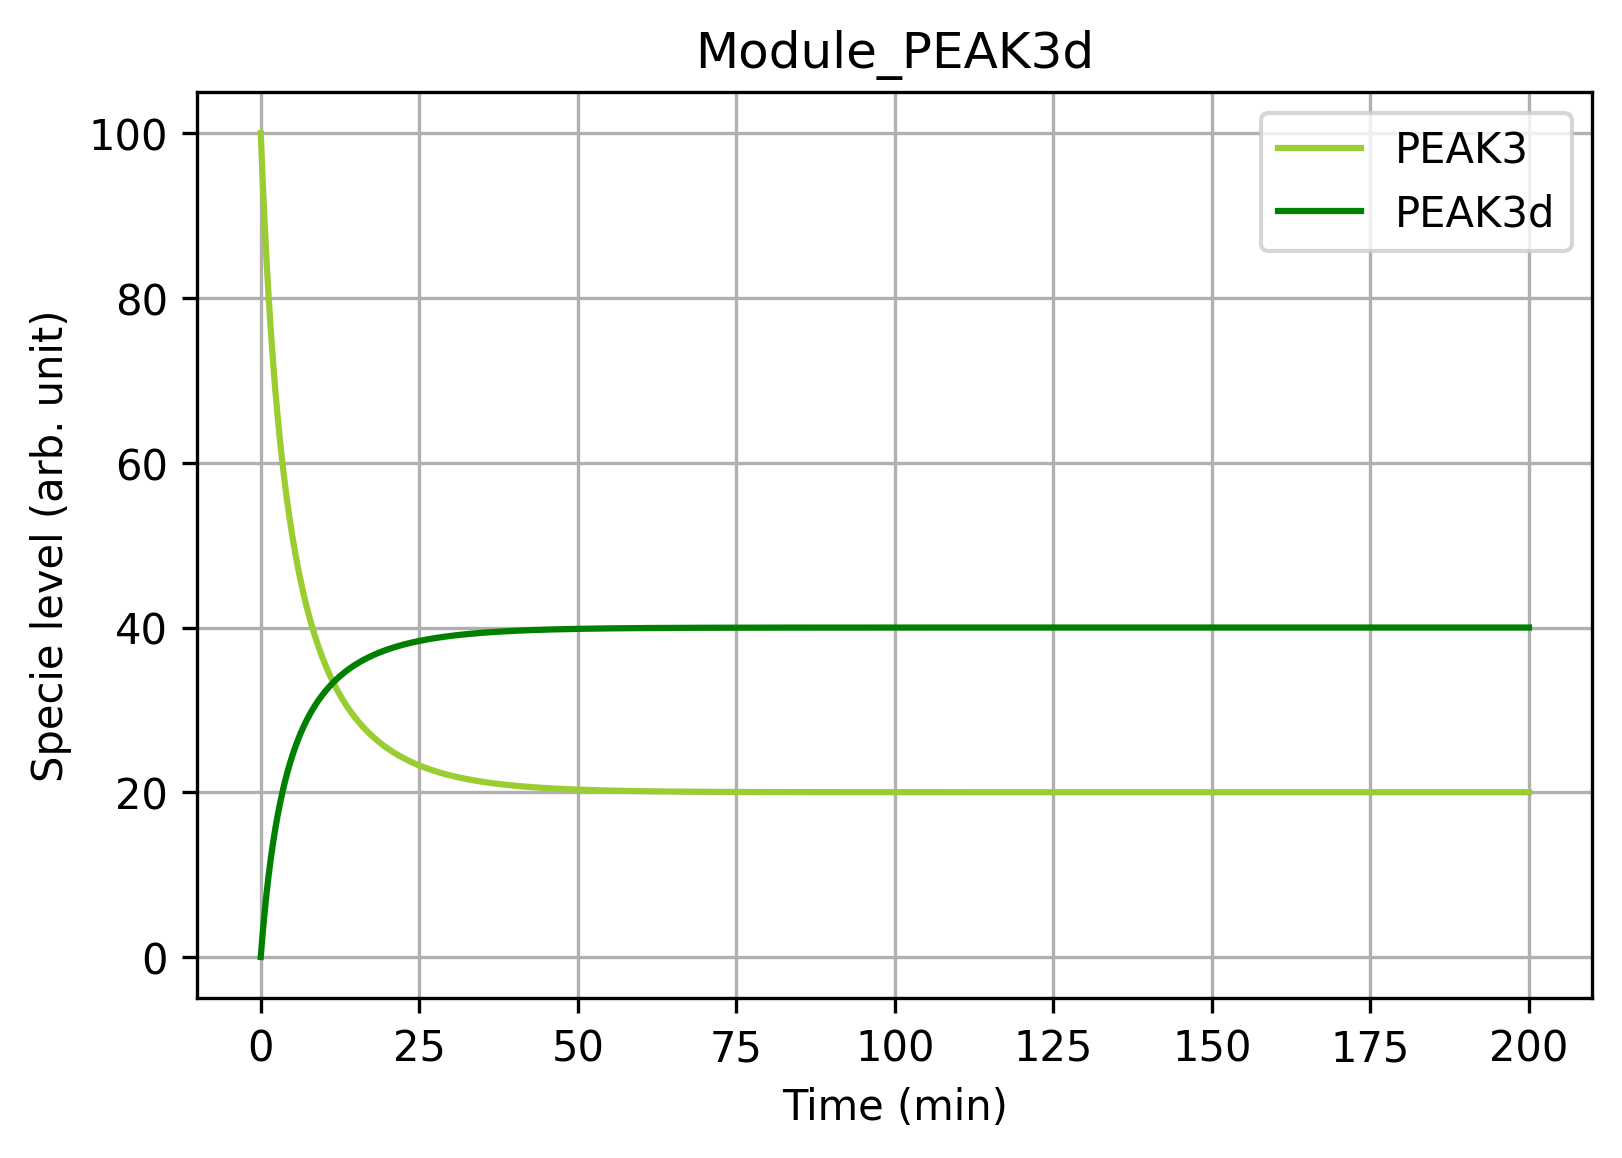

In [7]:
Module_PEAK3d = OdeModel('Module_PEAK3d')
Module_PEAK3d.addReaction(re.MassAction('PEAK3', 'PEAK3', 'PEAK3d'))
Module_PEAK3d.specieConc(['PEAK3'], [100])

Module_PEAK3d.simulate_beta(200)
Module_PEAK3d.plot(colours=['yellowgreen', 'green'], savefig=True, name="mpl-33-1")

# green-purple colour palette for PEAK3d

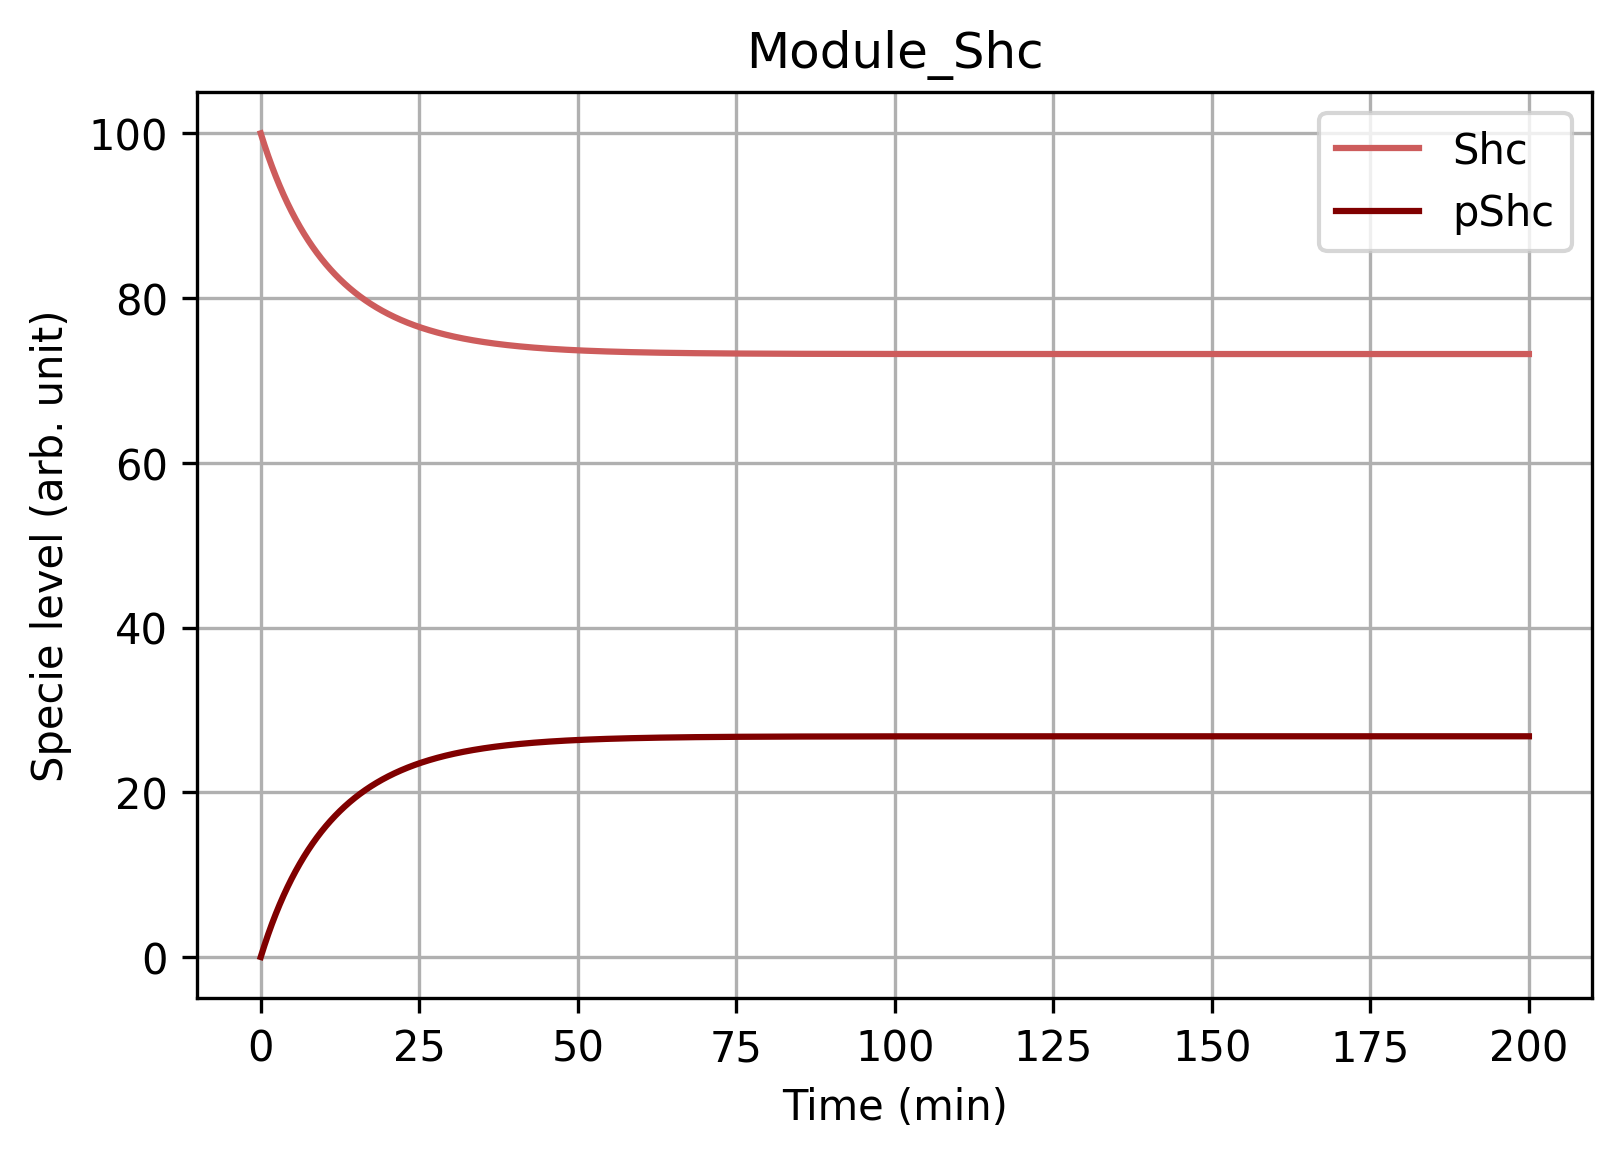

In [9]:
Module_Shc = OdeModel('Module_Shc')
Module_Shc.addReaction(re.MichaelisMentenGeneral('Shc', 'pShc'))
Module_Shc.specieConc(['Shc'], [100])

Module_Shc.addStimulator('Module_Shc_1', "pEGFR")
Module_Shc.setState('pEGFR', 50)

Module_Shc.simulate_beta(200)
Module_Shc.plot(ignore_list=['pEGFR'], colours=['indianred', 'maroon'],savefig=True, name="mpl-34-shc")


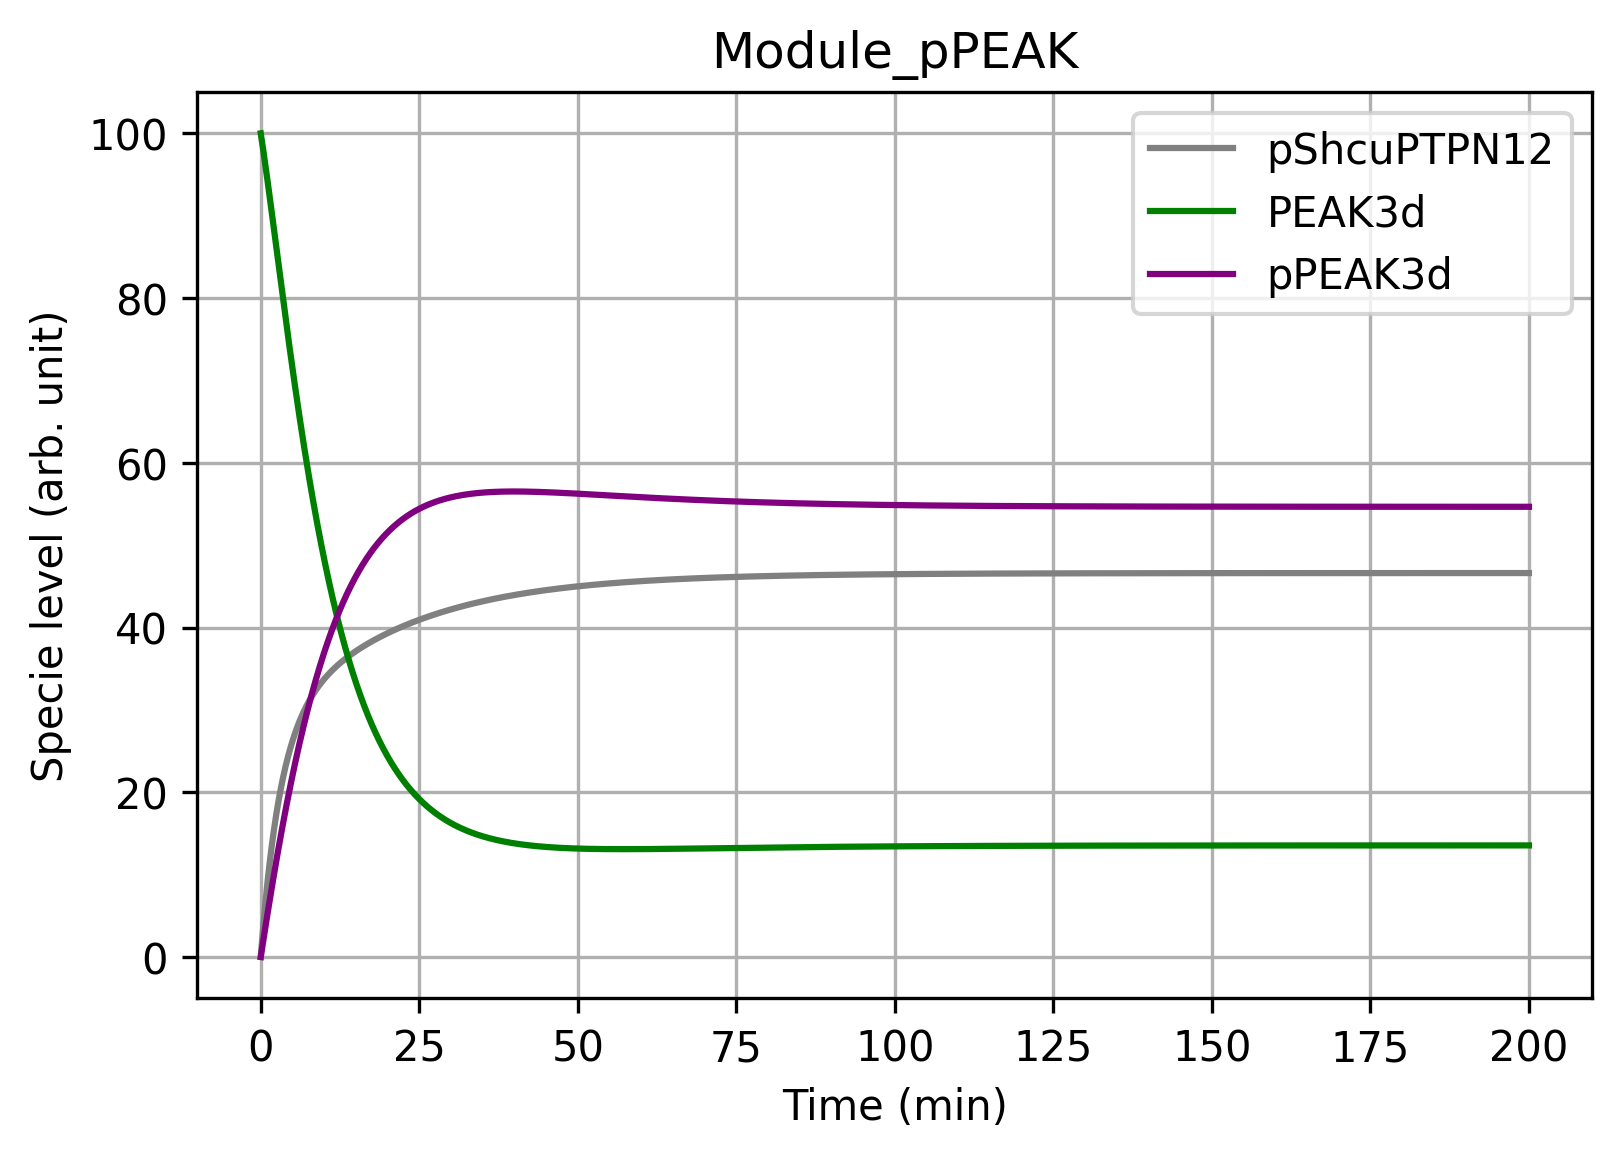

In [10]:
Module_pPEAK = OdeModel('Module_pPEAK')
Module_pPEAK.addReaction(re.MassAction('pShc', 'PTPN12'))
Module_pPEAK.addReaction(re.MichaelisMentenGeneral('PEAK3d', 'pPEAK3d', noBackward=True)) # Vmax also controls PEAK3d steady states, surprisingly
Module_pPEAK.addReaction(re.MassAction('pShcuPTPN12', 'PEAK3d', Kd=0.1)) # kd controls how much PEAK3d there are
Module_pPEAK.addReaction(re.MassAction('pShcuPTPN12', 'pPEAK3d', Kd=0.1)) # Ka controls how much pPEAK3d there are
Module_pPEAK.addReaction(re.MichaelisMentenGeneral('pShcuPTPN12upPEAK3d', 'pShcuPTPN12uPEAK3d', noBackward=True))

Module_pPEAK.specieConc(['pShc', 'PEAK3d'], [100, 100]) # INPUT: pShc controls the steady state of pPEAK3d and PEAK3d
Module_pPEAK.specieConc(['PTPN12'], [100])

Module_pPEAK.simulate_beta(200)
Module_pPEAK.plot(ignore_list=['pShcuPTPN12upPEAK3d', 'pShcuPTPN12uPEAK3d', 'PTPN12', 'pShc'], colours=['grey','green','purple'], savefig=True, name="mpl-35-pPEAK")


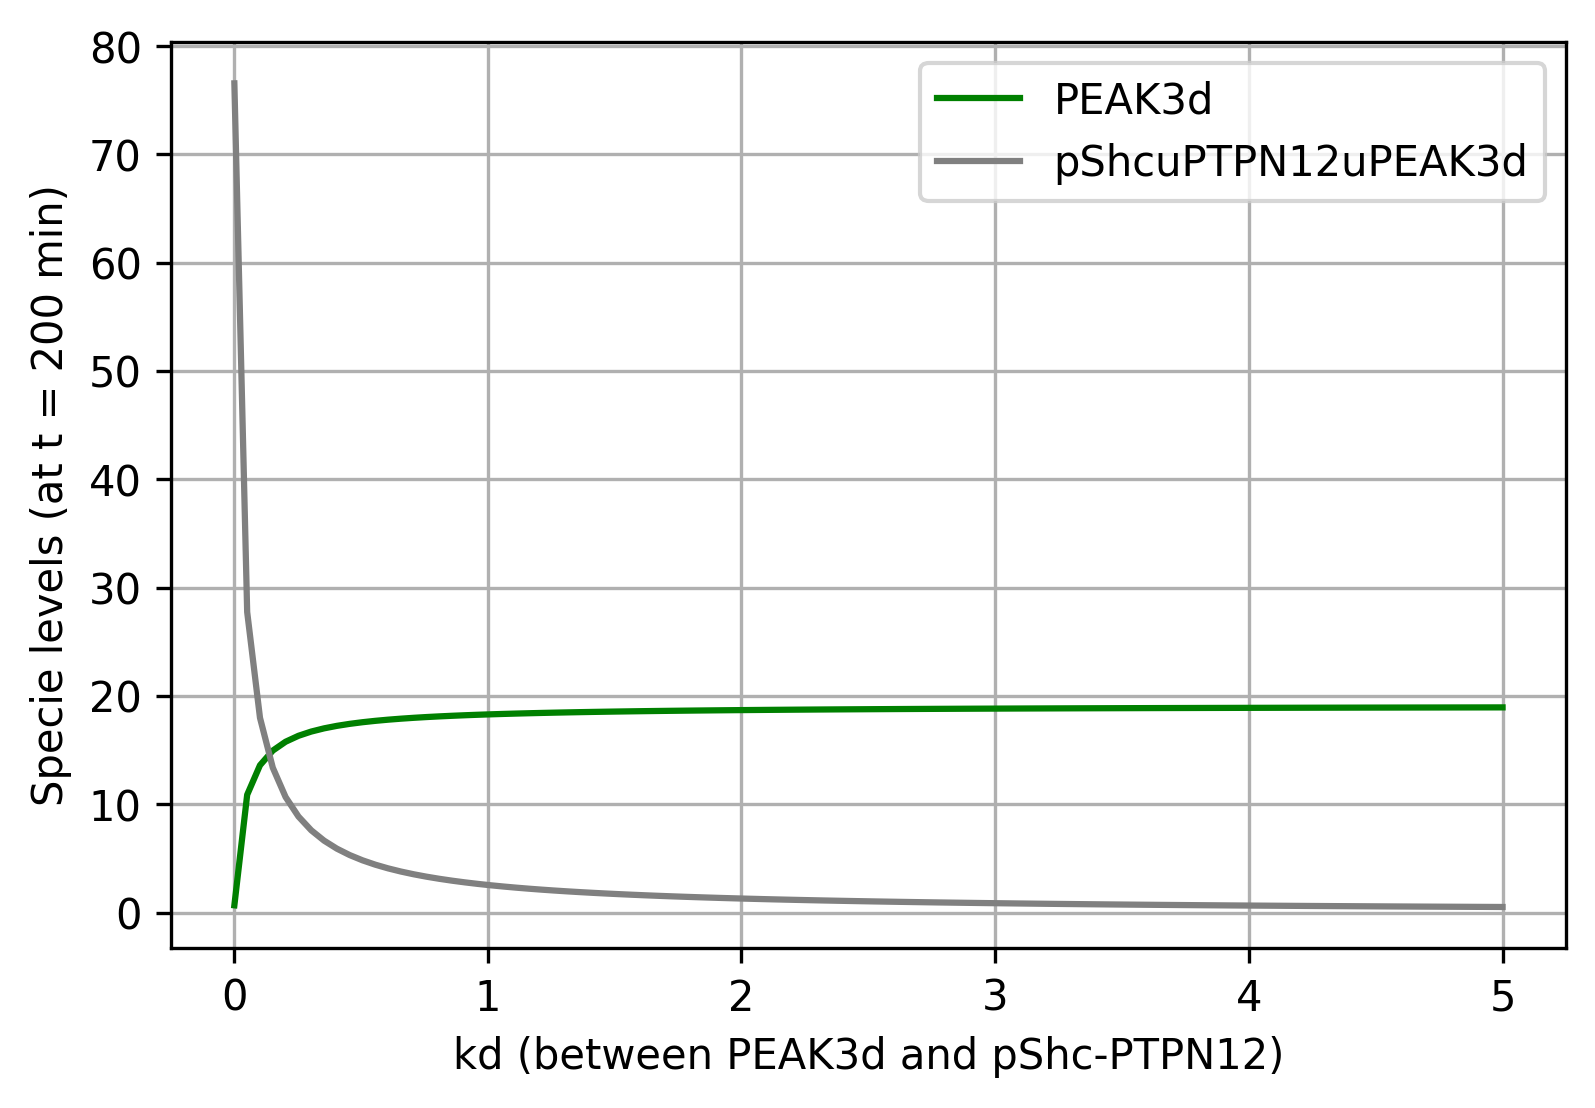

In [11]:
# Further analysis on Module_pPEAK
# input: (kd) dissociation constant for PEAK3d and pShc-PTPN12 complex
# output: PEAK3d, pShcuPTPN12uPEAK3d

output_list = []
output_var = 'PEAK3d'

o2l = []
o2 = 'pShcuPTPN12uPEAK3d'

p_range = np.linspace(0.001, 5, 100)
for p in p_range:
    Module_pPEAK.setParam('Module_pPEAK_3', 'kd', p)
    Module_pPEAK.simulate_beta(200)
    o = Module_pPEAK.extractStateValues(output_var)[-1]
    output_list.append(o)
    o2_ = Module_pPEAK.extractStateValues(o2)[-1]
    o2l.append(o2_)

plt.plot(p_range, output_list, label=output_var, c='g')
plt.plot(p_range, o2l, label=o2, c='grey')
# plt.xscale('log')
plt.legend()
plt.grid()
plt.xlabel('kd (between PEAK3d and pShc-PTPN12)')
plt.ylabel('Specie levels (at t = 200 min)')

plt.savefig('mpl-35-pPEAK-kd', dpi=300)
plt.show()


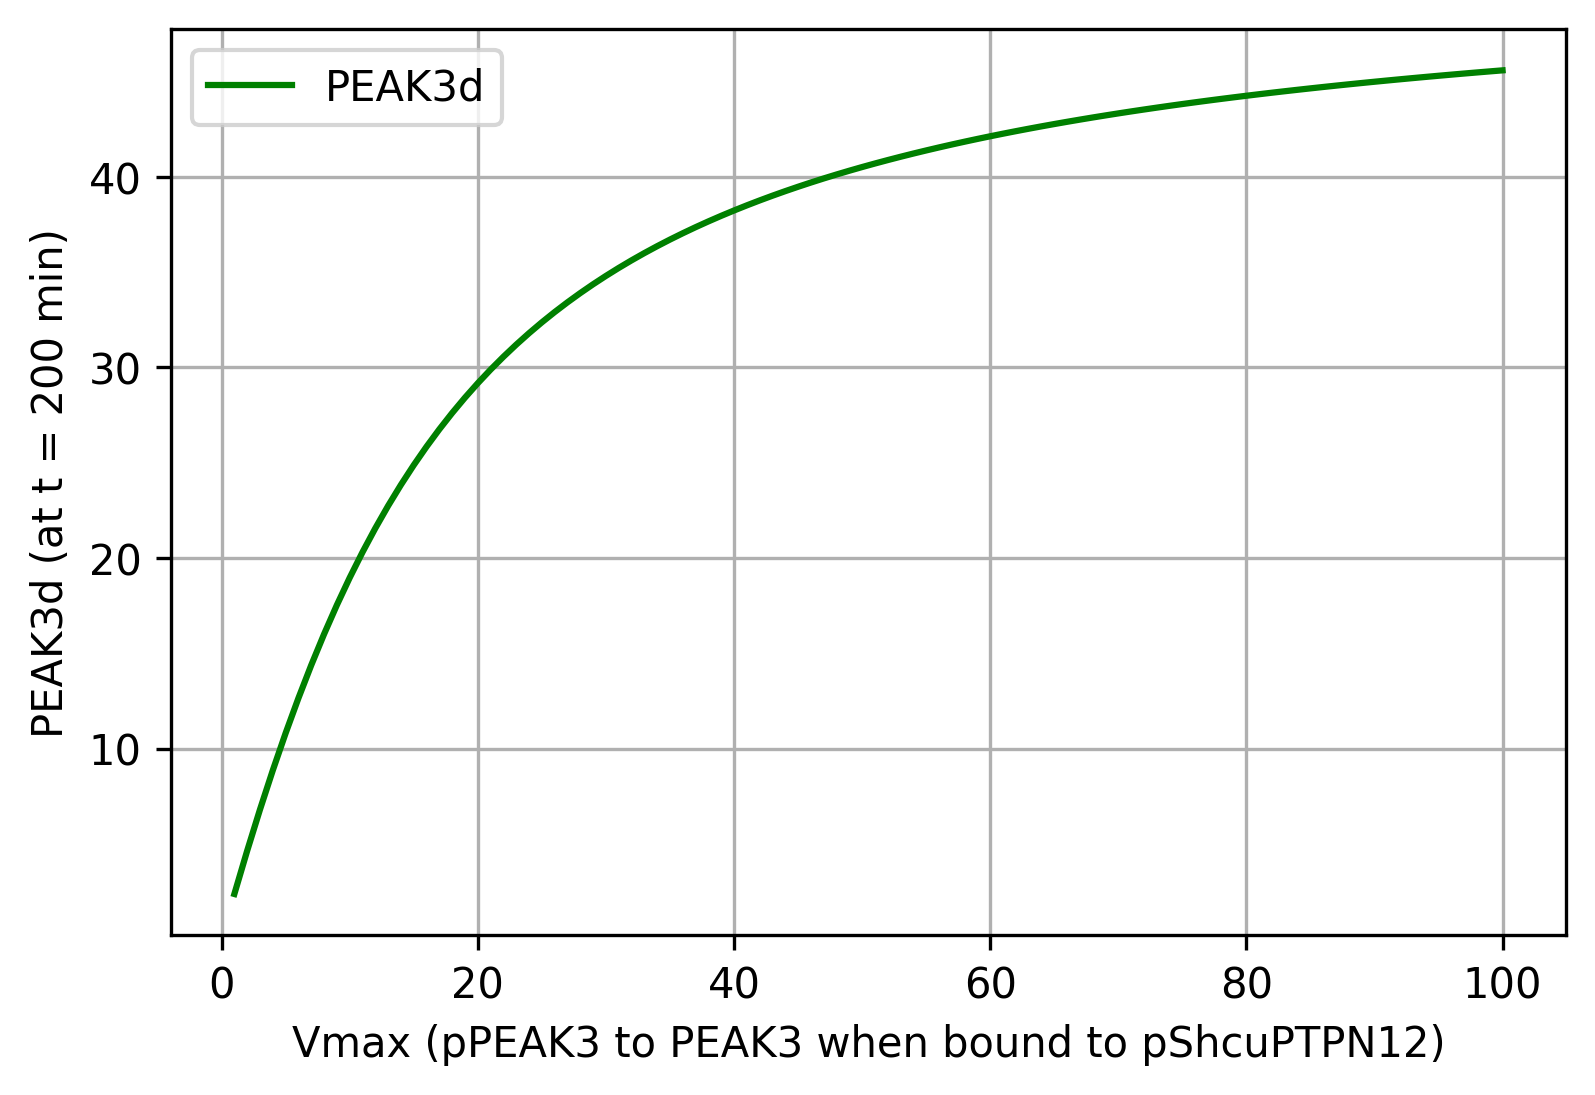

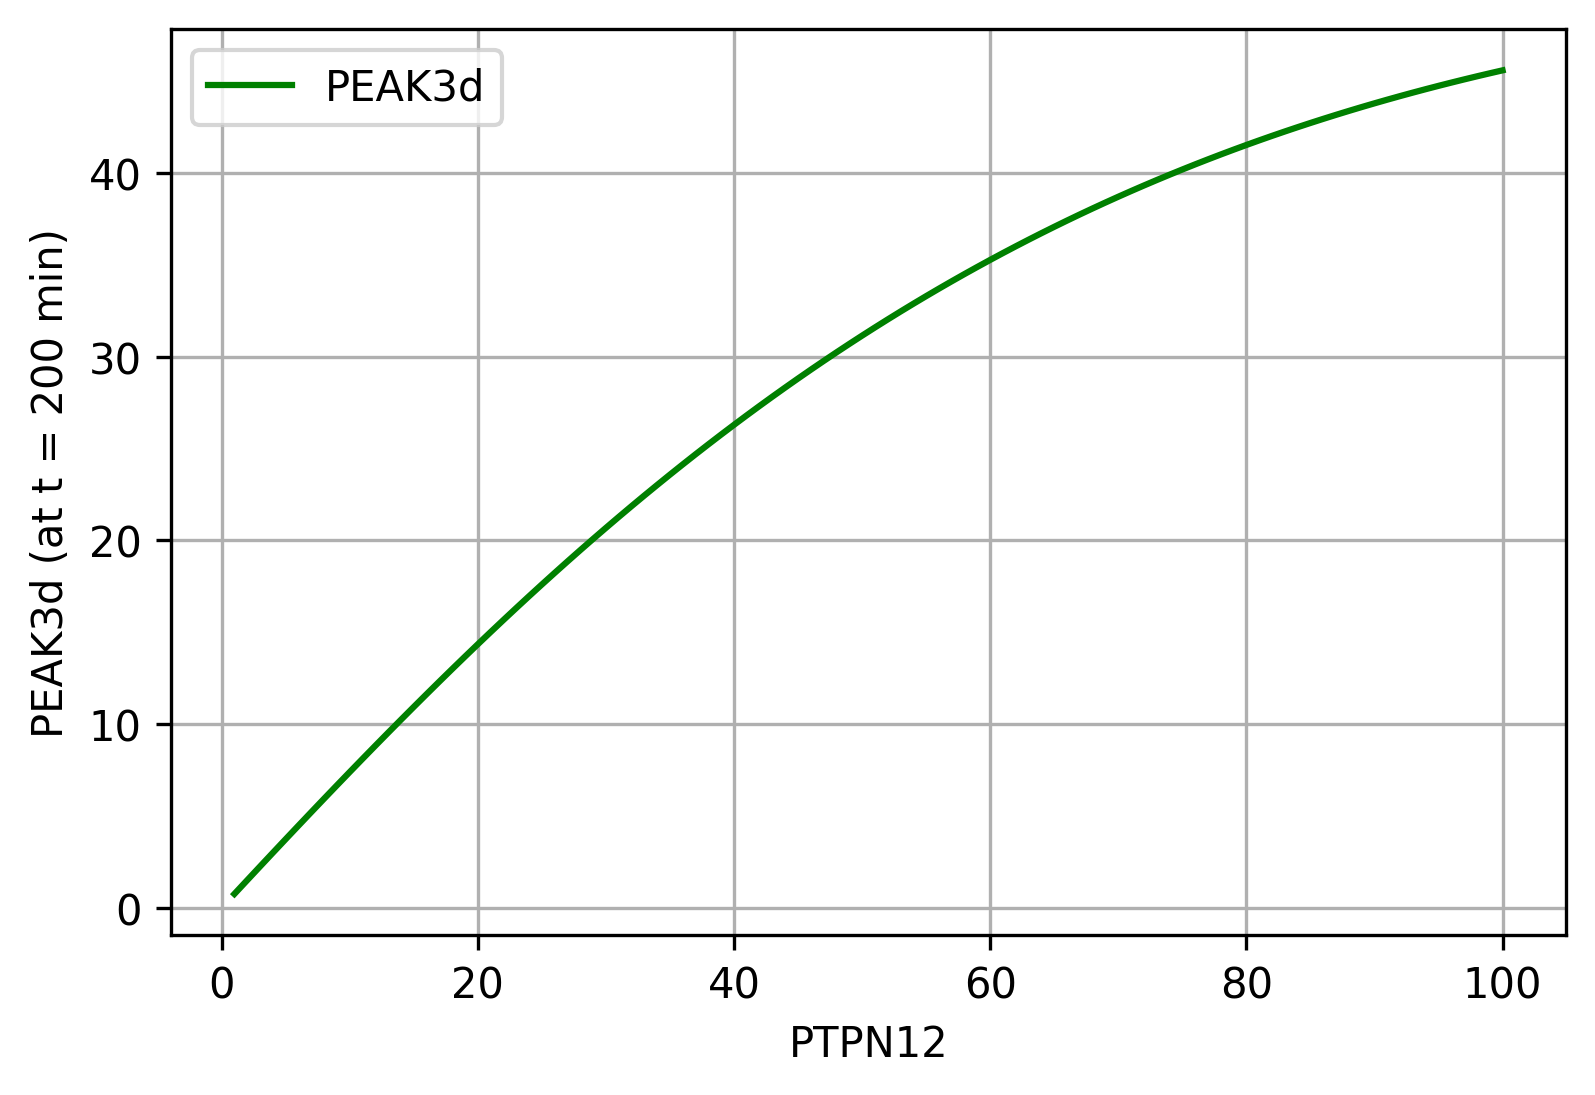

In [12]:
# Analysing Module_pPEAK a bit further... 

peak3d_list = []
other_list = []

p_range = np.linspace(1,100,100)
for p in p_range:
    Module_pPEAK.setParam('Module_pPEAK_5', 'vmaxf', p)
    Module_pPEAK.simulate_beta(200)
    peak3d = Module_pPEAK.extractStateValues('PEAK3d')[-1]
    other = Module_pPEAK.extractStateValues('pShcuPTPN12uPEAK3d')[-1]
    peak3d_list.append(peak3d)
    other_list.append(other)

plt.plot(p_range, peak3d_list, label='PEAK3d', c='g')
plt.legend()
plt.grid()
plt.xlabel('Vmax (pPEAK3 to PEAK3 when bound to pShcuPTPN12)')
plt.ylabel('PEAK3d (at t = 200 min)')

# plt.plot(kd_range, other_list)
plt.savefig('mpl-35-pPEAK-Vmax', dpi=300)
plt.show()

peak3d_list = []

p_range = np.linspace(1, 100, 100)
for p in p_range:
    Module_pPEAK.setState('PTPN12', p)
    Module_pPEAK.simulate_beta(200)
    peak3d = Module_pPEAK.extractStateValues('PEAK3d')[-1]
    peak3d_list.append(peak3d)

plt.plot(p_range, peak3d_list, label='PEAK3d', c='g')
plt.legend()
plt.grid()
plt.xlabel('PTPN12')
plt.ylabel('PEAK3d (at t = 200 min)')
plt.savefig('mpl-35-pPEAK-ptpn12', dpi=300)
plt.show()


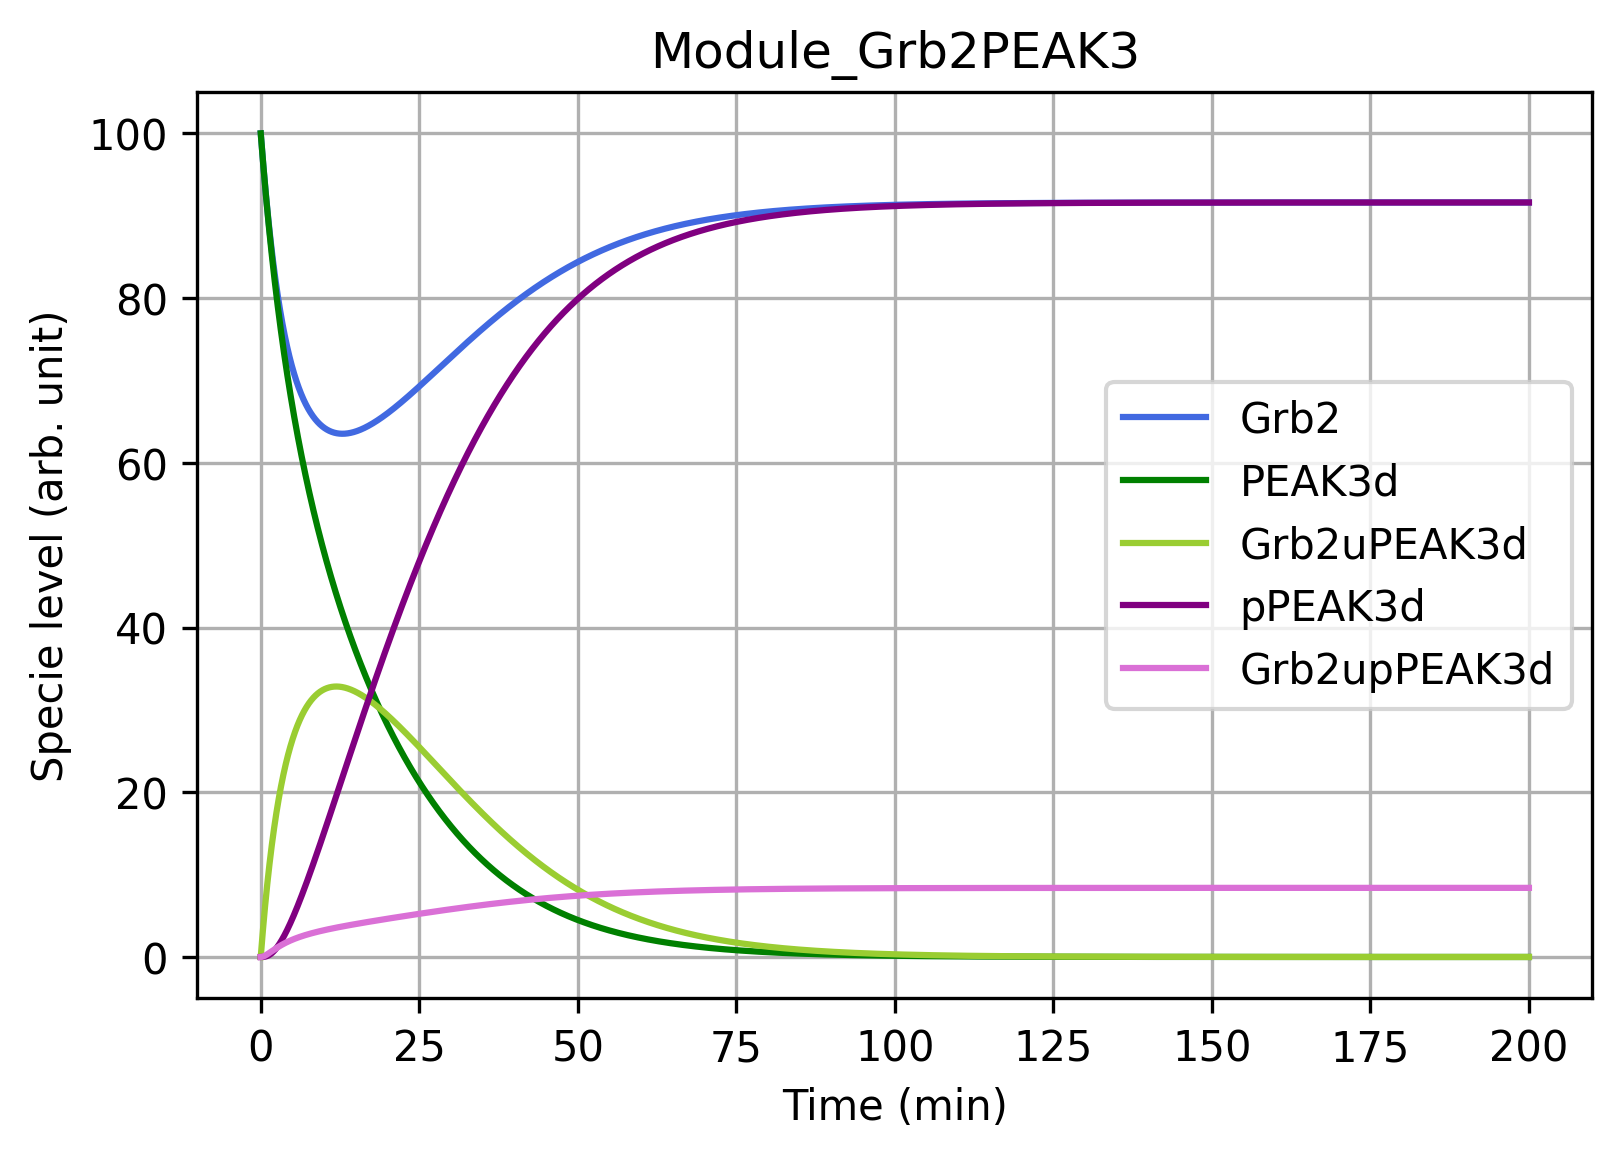

In [13]:
Module_Grb2PEAK3 = OdeModel('Module_Grb2PEAK3')
Module_Grb2PEAK3.addReaction(re.MassAction('Grb2', 'PEAK3d'))
Module_Grb2PEAK3.addReaction(re.MassAction('Grb2', 'pPEAK3d', Kd=1))
Module_Grb2PEAK3.addReaction(re.MichaelisMentenGeneral('Grb2uPEAK3d', 'Grb2upPEAK3d', noBackward=True))
Module_Grb2PEAK3.addStimulator('Module_Grb2PEAK3_3', 'aSFK')

Module_Grb2PEAK3.setState('aSFK', 100)
Module_Grb2PEAK3.specieConc(['Grb2', 'PEAK3d'], [100, 100])
Module_Grb2PEAK3.simulate_beta(200)
Module_Grb2PEAK3.plot(ignore_list=['aSFK'],colours=['royalblue','green','yellowgreen','purple','orchid'], savefig=True, name="mpl-36-Grb2PEAK3")


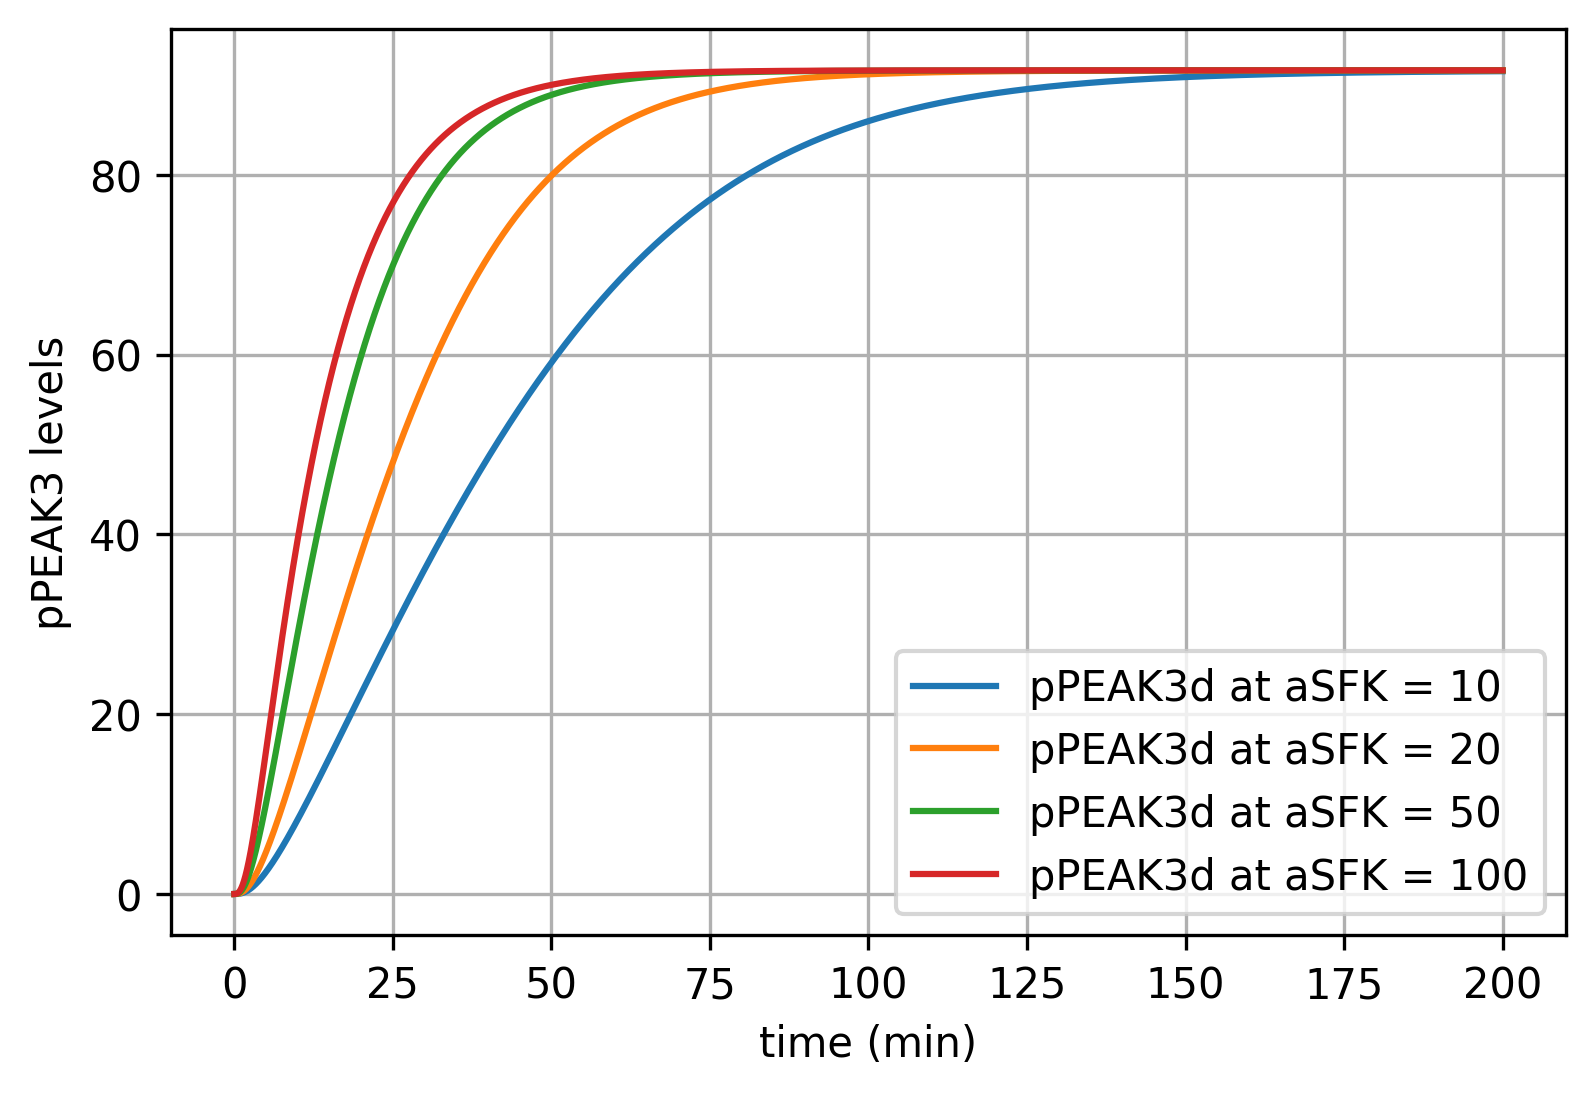

In [14]:
# In Module_Grb2PEAK3, due to its special structure involved with Grb2,
# aSFK concentrations only determines how fast PEAK3d is converted to pPEAK3d, 
# but not the steady state of pPEAK3d. I demonstrate this by plotting pPEAK3d 
# conc. against different aSFK concentrations
# I hypothesise this is due to Grb2 forming an internal 'loop' with PEAK3d and pPEAK3d 
# the loop is only caused by the one-way michaelian phosphorylation 

p_range = [10, 20, 50, 100]
output_var = 'pPEAK3d'

for p in p_range:
    Module_Grb2PEAK3.setState('aSFK', p)
    Module_Grb2PEAK3.setParam('Module_Grb2PEAK3_3', 'kcf_aSFK', 0.5)
    Module_Grb2PEAK3.simulate_beta(200)
    o = Module_Grb2PEAK3.extractStateValues(output_var)
    plt.plot(Module_Grb2PEAK3.t, o, label='{o} at aSFK = {n}'.format(o=output_var, n=str(p)))

plt.legend()
plt.grid()
plt.xlabel('time (min)')
plt.ylabel('pPEAK3 levels')

plt.savefig('mpl-36-Grb2PEAK3-aSFK.png')
plt.show()


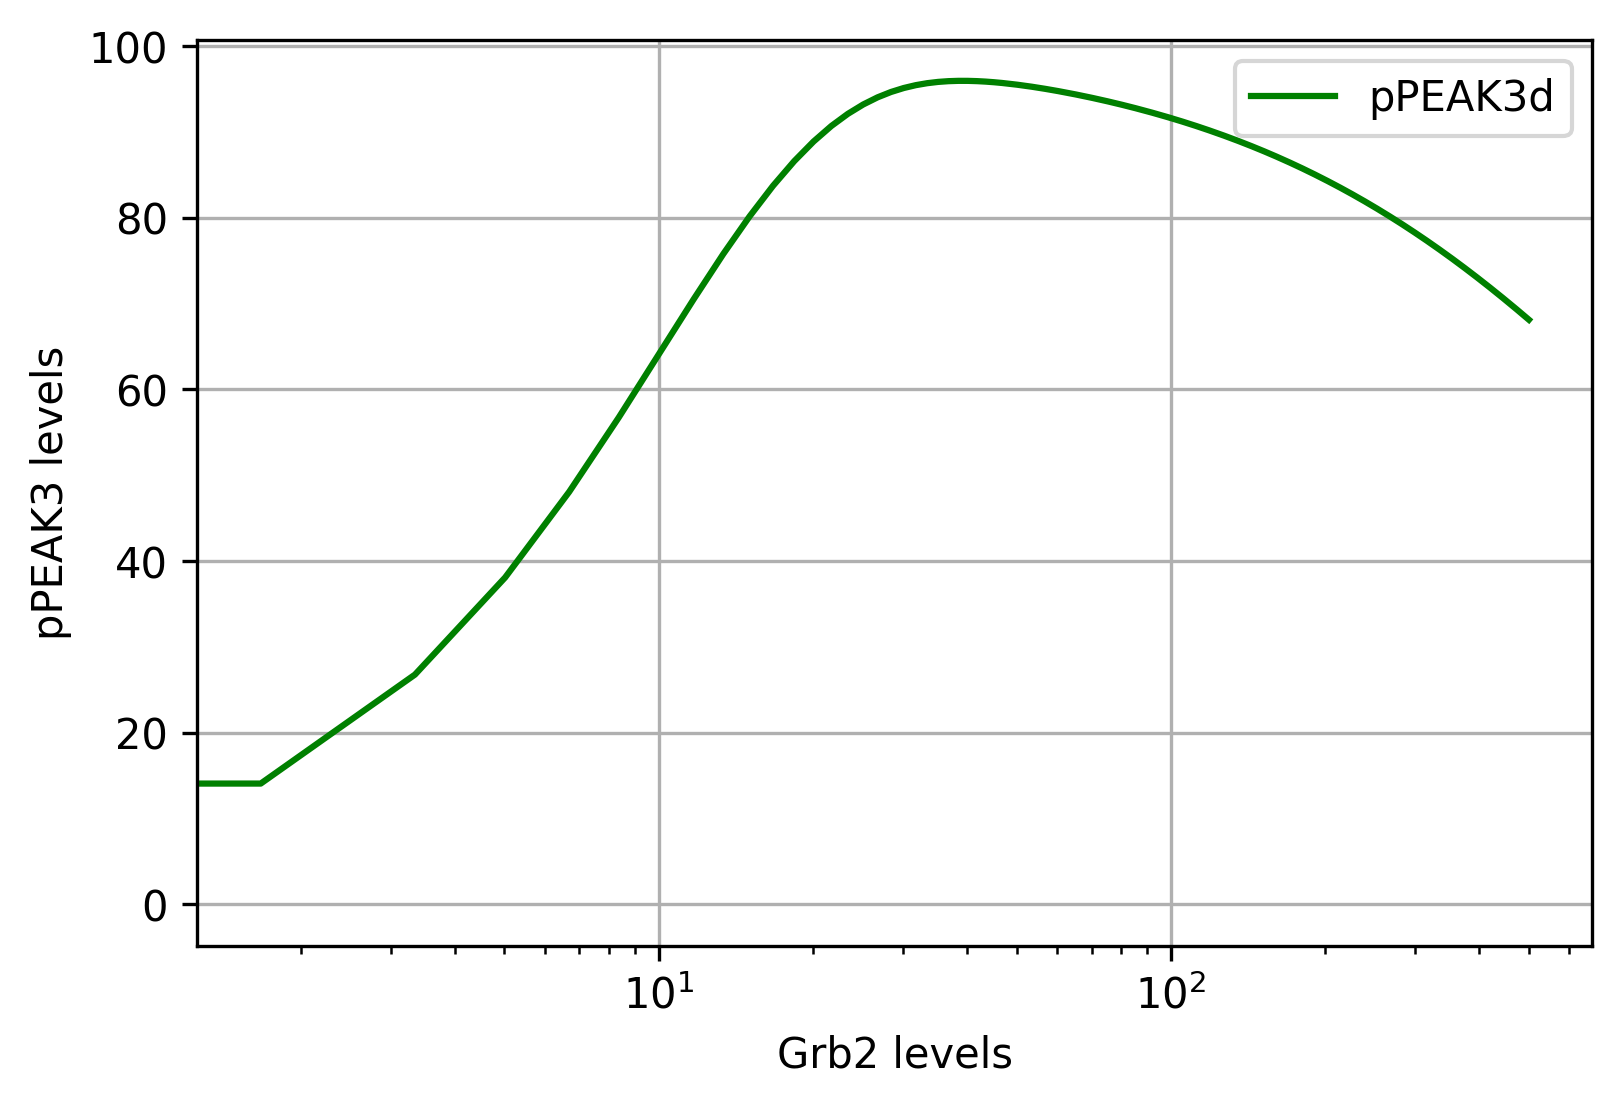

In [16]:
# I now show that, Grb2 conc. controls pPEAK3d concentration

Module_Grb2PEAK3.setParam('Module_Grb2PEAK3_3', 'kcf_aSFK', 0.1) # reset parameter
Module_Grb2PEAK3.setState('aSFK', 100)

output_list = []
output_var = 'pPEAK3d'
p_range = np.linspace(0, 500, 300)

for p in p_range:
    Module_Grb2PEAK3.setState('Grb2', p)
    Module_Grb2PEAK3.simulate_beta(200)
    o = Module_Grb2PEAK3.extractStateValues(output_var)[-1]
    output_list.append(o)

plt.plot(p_range, output_list, label=output_var, c='g')
plt.legend()
plt.grid()
plt.xlabel('Grb2 levels')
plt.xscale('log')
plt.ylabel('pPEAK3 levels')
plt.savefig('mpl-36-Grb2PEAK3-Grb2.png')
plt.show()

# the tailend is not necessarily accurate due to poor sampling
Module_Grb2PEAK3.setState('Grb2', 100)  # reset this


The next part of code are for testing only

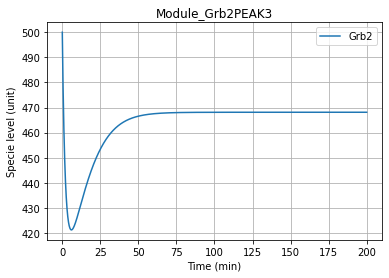

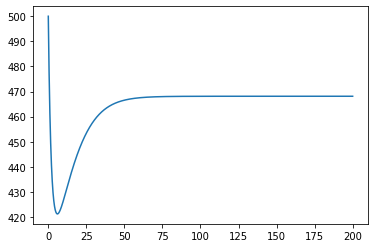

In [14]:
Module_Grb2PEAK3.plotOnly(only_print=['Grb2'])

a = Module_Grb2PEAK3.extractStateValues('Grb2')

# print(a[-1])

plt.plot(Module_Grb2PEAK3.t, a)
plt.show()


In [15]:
# We combine Module_pPEAK3 with Module_Grb2PEAK3

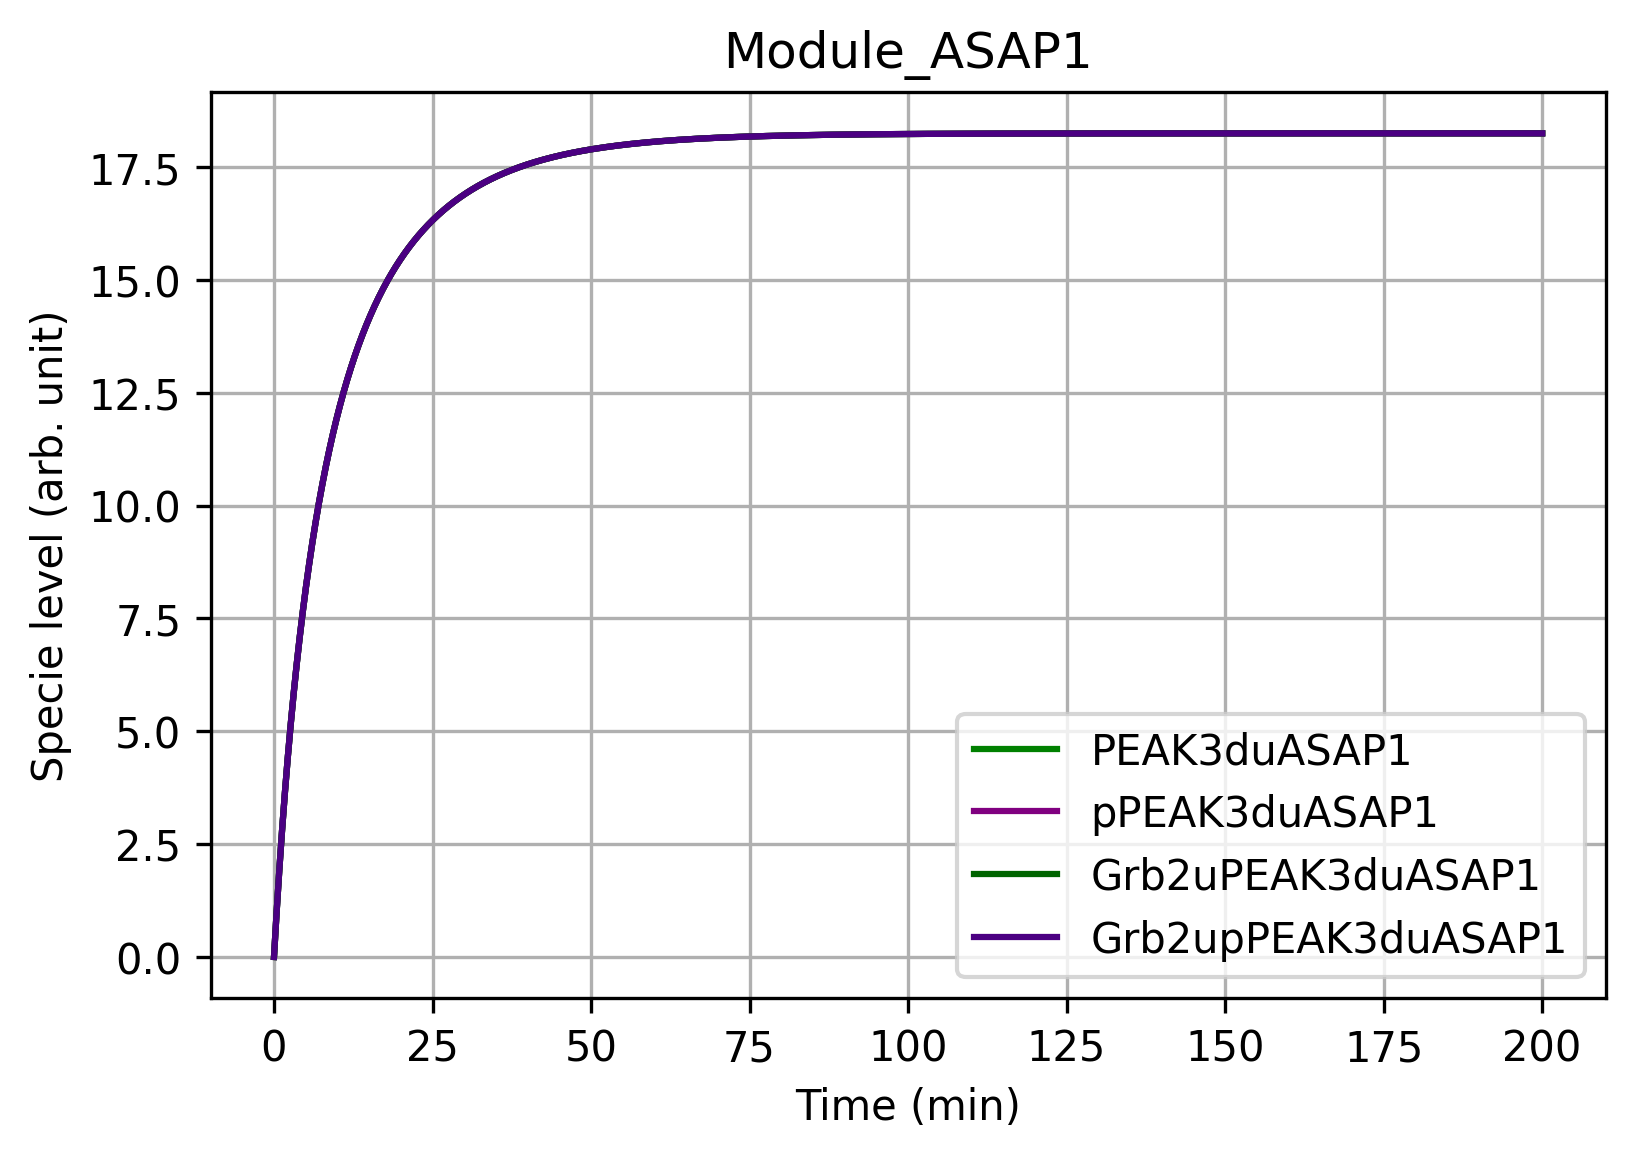

18.24607131437906


In [17]:
Module_ASAP1 = OdeModel('Module_ASAP1')
target = 'ASAP1'

peak3_vars = ['PEAK3d', 'pPEAK3d', 'Grb2uPEAK3d', 'Grb2upPEAK3d']
for p in peak3_vars:
    Module_ASAP1.addReaction(re.MassAction(p, target))

Module_ASAP1.specieConc(peak3_vars, [25, 25, 25, 25]) 
# ^ changing peak3 var conc. changes not only the corresponding peak3 var. bound ASAP1
# it also changes other PEAK3 var. bound ASAP1 conc. 
Module_ASAP1.setState(target, 100) # ASAP1 uniformly changes all bound ASAP1 species

ignore = peak3_vars.copy()
ignore.append(target)
Module_ASAP1.simulate_beta(200)
Module_ASAP1.plot(ignore_list=ignore, colours=['green', 'purple', 'darkgreen','indigo'], savefig=True, name="mpl-37-asap1")

print(Module_ASAP1.extractStateValues('PEAK3duASAP1')[-1])

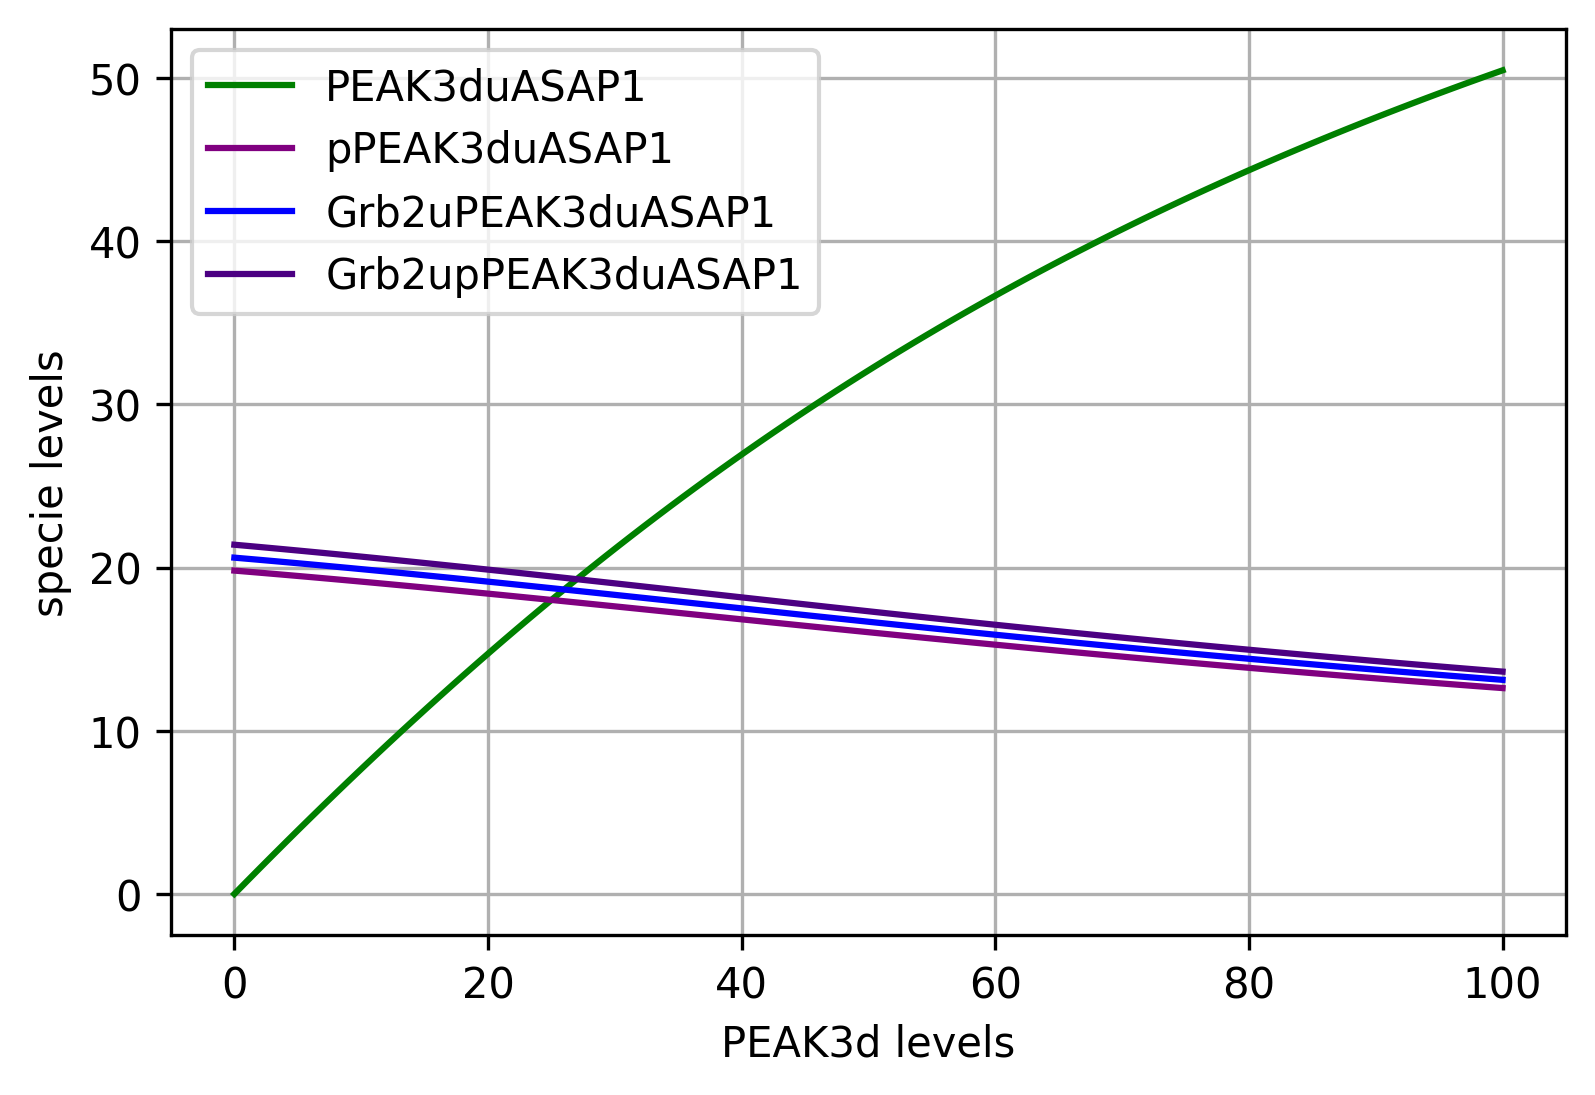

In [18]:
# We show that the conc. of one PEAK3 var. will change the conc. of other PEAK3
# var. bound to ASAP1

# inc. in one unbound specie downregulates all other bound ones 
# dec. in one unbound specie upregulates all other bound ones

# use PEAK3d as an example demonstration 

Module_ASAP1.specieConc(peak3_vars, [25, 25, 26, 27]) # slight diff to visualise better

output_list = [[], [], [], []]
output_var = ['PEAK3duASAP1', 'pPEAK3duASAP1', 'Grb2uPEAK3duASAP1', 'Grb2upPEAK3duASAP1']
p_range = np.linspace(0, 100, 100)

for p in p_range:
    Module_ASAP1.setState('PEAK3d', p)
    Module_ASAP1.simulate_beta(200)
    i = 0 
    while i < len(output_list):
        o = Module_ASAP1.extractStateValues(output_var[i])[-1]
        output_list[i].append(o)
        i += 1

colours = ['green', 'purple', 'blue', 'indigo']
i = 0 
while i < len(output_list):
    plt.plot(p_range, output_list[i], label=output_var[i], c=colours[i])
    i += 1

plt.legend()
plt.grid()
plt.xlabel('PEAK3d levels')
# plt.xscale('log')
plt.ylabel('specie levels')
plt.savefig('mpl-37-asap1-peak3d.png')
plt.show()

Module_ASAP1.specieConc(peak3_vars, [25, 25, 25, 25]) # reset variables


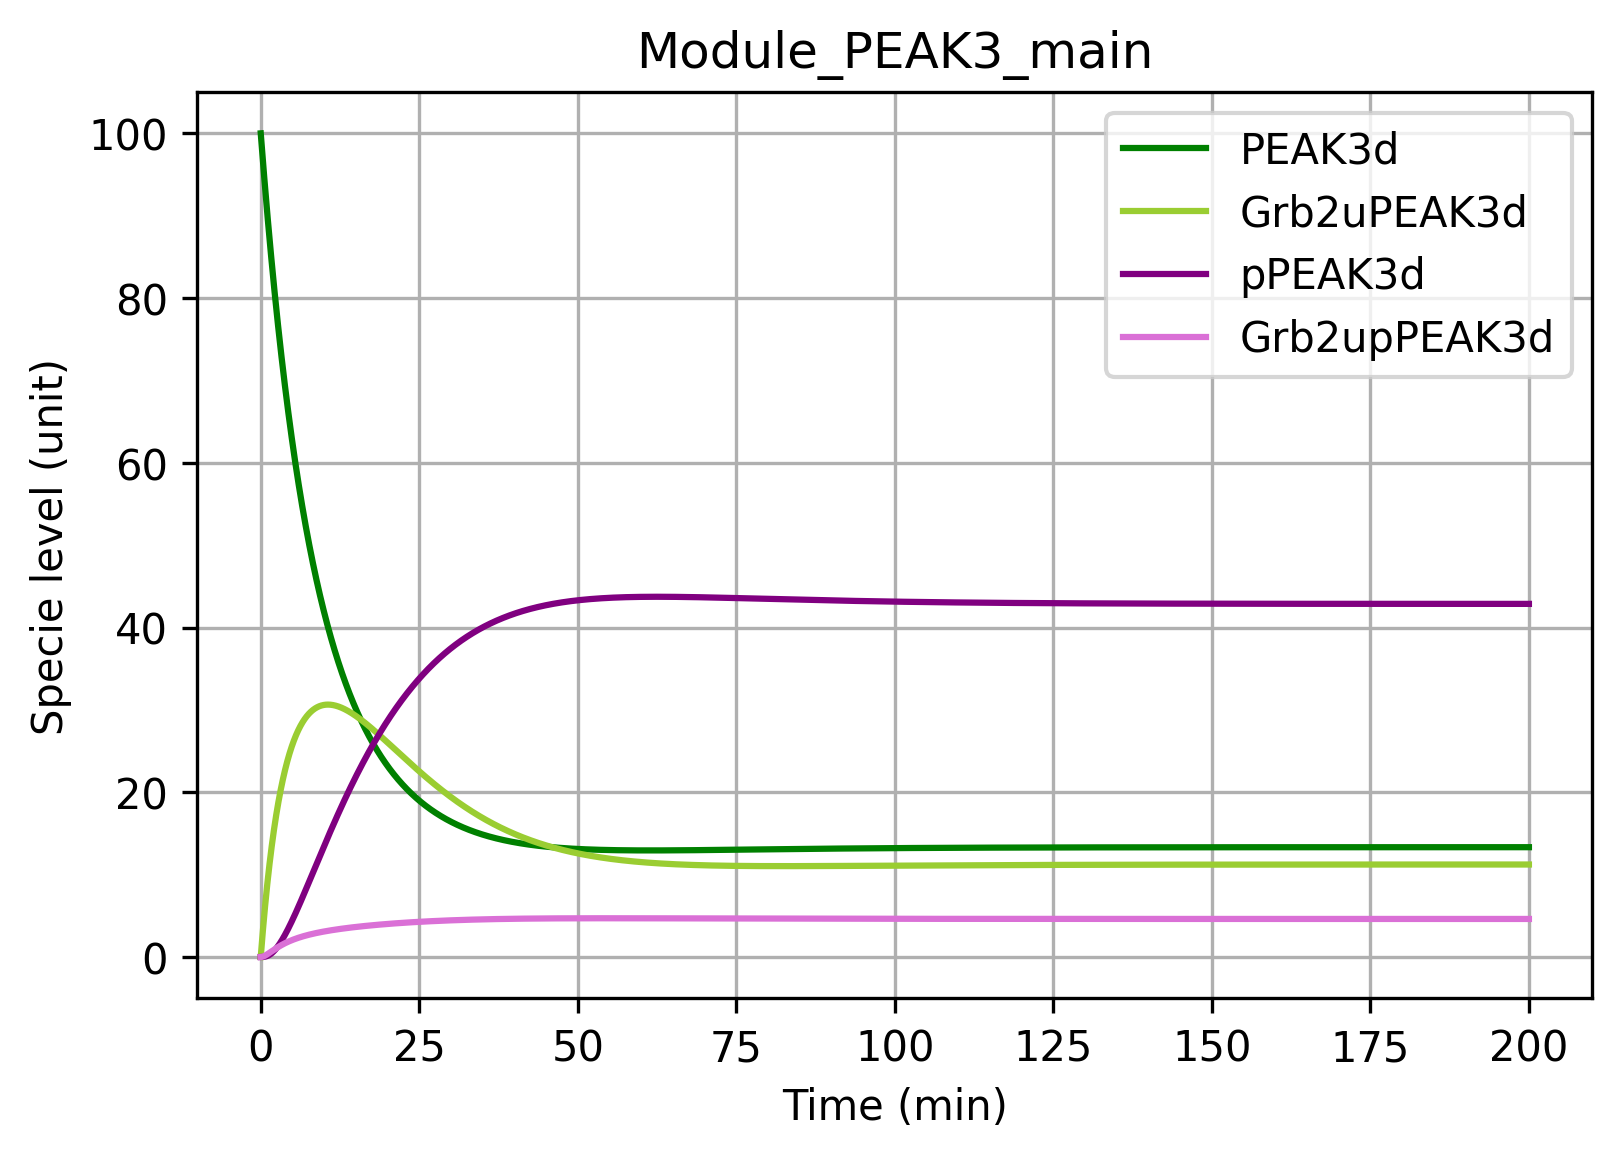

In [19]:
# Combining module_pPEAK and module_Grb2PEAK3

# first, we remove PEAK3d -> pPEAK3d in module_pPEAK

# pShc (also PTPN12) and aSFK act as main controllers (input) of this module

# level of PEAK3d and Grb2 can also be of interest 

# PEAK3d / pPEAK3d / Grb2 bound PEAK3d / pPEAK3d are the 4 primary outputs of this module
# since they directly interface downstream with ASAP1, Cbl, PYK2 and CrkII binding

# reconstructed pPEAK module, I remove PEAK3d -> pPEAK3d in module_pPEAK
Module_pPEAK2 = OdeModel('Module_pPEAK2')
Module_pPEAK2.addReaction(re.MassAction('pShc', 'PTPN12'))
Module_pPEAK2.addReaction(re.MassAction('pShcuPTPN12', 'PEAK3d', Kd=0.1)) # kd controls how much PEAK3d there are
Module_pPEAK2.addReaction(re.MassAction('pShcuPTPN12', 'pPEAK3d', Kd=0.1)) # Ka controls how much pPEAK3d there are
Module_pPEAK2.addReaction(re.MichaelisMentenGeneral('pShcuPTPN12upPEAK3d', 'pShcuPTPN12uPEAK3d', noBackward=True))

Module_pPEAK2.specieConc(['pShc', 'PEAK3d'], [100, 100]) # INPUT: pShc controls the steady state of pPEAK3d and PEAK3d
Module_pPEAK2.specieConc(['PTPN12'], [100]) # PTPN12 controls steady state of output var. (inc. PEAK3d)

import copy

Module_Grb2PEAK3_2 = copy.deepcopy(Module_Grb2PEAK3) # copy instead of combine straight away
# Module_Grb2PEAK3.setState('Grb2', 100) # testing if deepcopy worked, these copy methods work strangely with jupyter notebooks

Module_PEAK3_main = Module_Grb2PEAK3_2.combine(Module_pPEAK2, 'Module_PEAK3_main')

Module_PEAK3_main.simulate_beta(200)
Module_PEAK3_main.plotOnly(only_print=peak3_vars, colours=['green', 'yellowgreen', 'purple', 'orchid'], savefig=True, name="mpl-38-main")


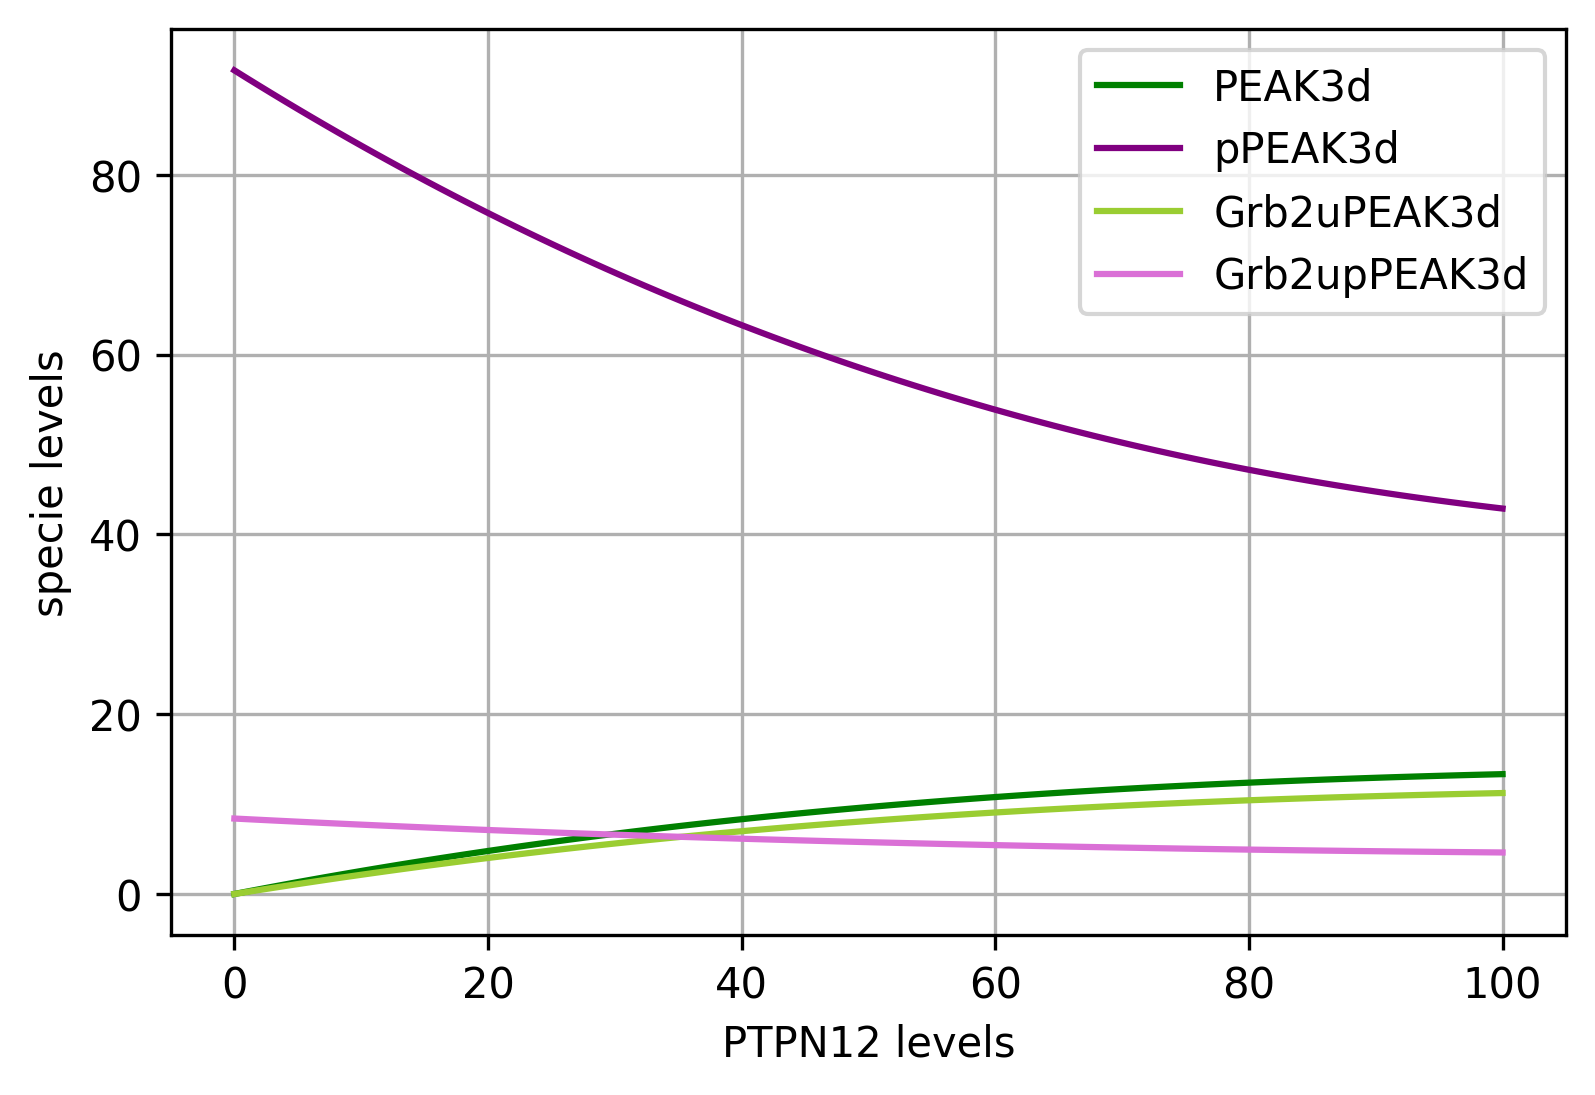

In [20]:
# IO Analysis: PTPN12 / pShc (I) -> all output var.

output_list = [[], [], [], []]
output_var = ['PEAK3d', 'pPEAK3d', 'Grb2uPEAK3d', 'Grb2upPEAK3d']
p_range = np.linspace(0, 100, 100)
input_state = "PTPN12"

for p in p_range:
    Module_PEAK3_main.setState(input_state, p)
    Module_PEAK3_main.simulate_beta(200)
    i = 0 
    while i < len(output_list):
        o = Module_PEAK3_main.extractStateValues(output_var[i])[-1]
        output_list[i].append(o)
        i += 1

colours = ['green', 'purple', 'yellowgreen', 'orchid']
i = 0 
while i < len(output_list):
    plt.plot(p_range, output_list[i], label=output_var[i], c=colours[i])
    i += 1

plt.legend()
plt.grid()
plt.xlabel('{i} levels'.format(i=input_state))
# plt.xscale('log')
plt.ylabel('specie levels')
plt.savefig('mpl-38-main-ptpn12')
plt.show()

Module_PEAK3_main.setState(input_state, 100)  # reset


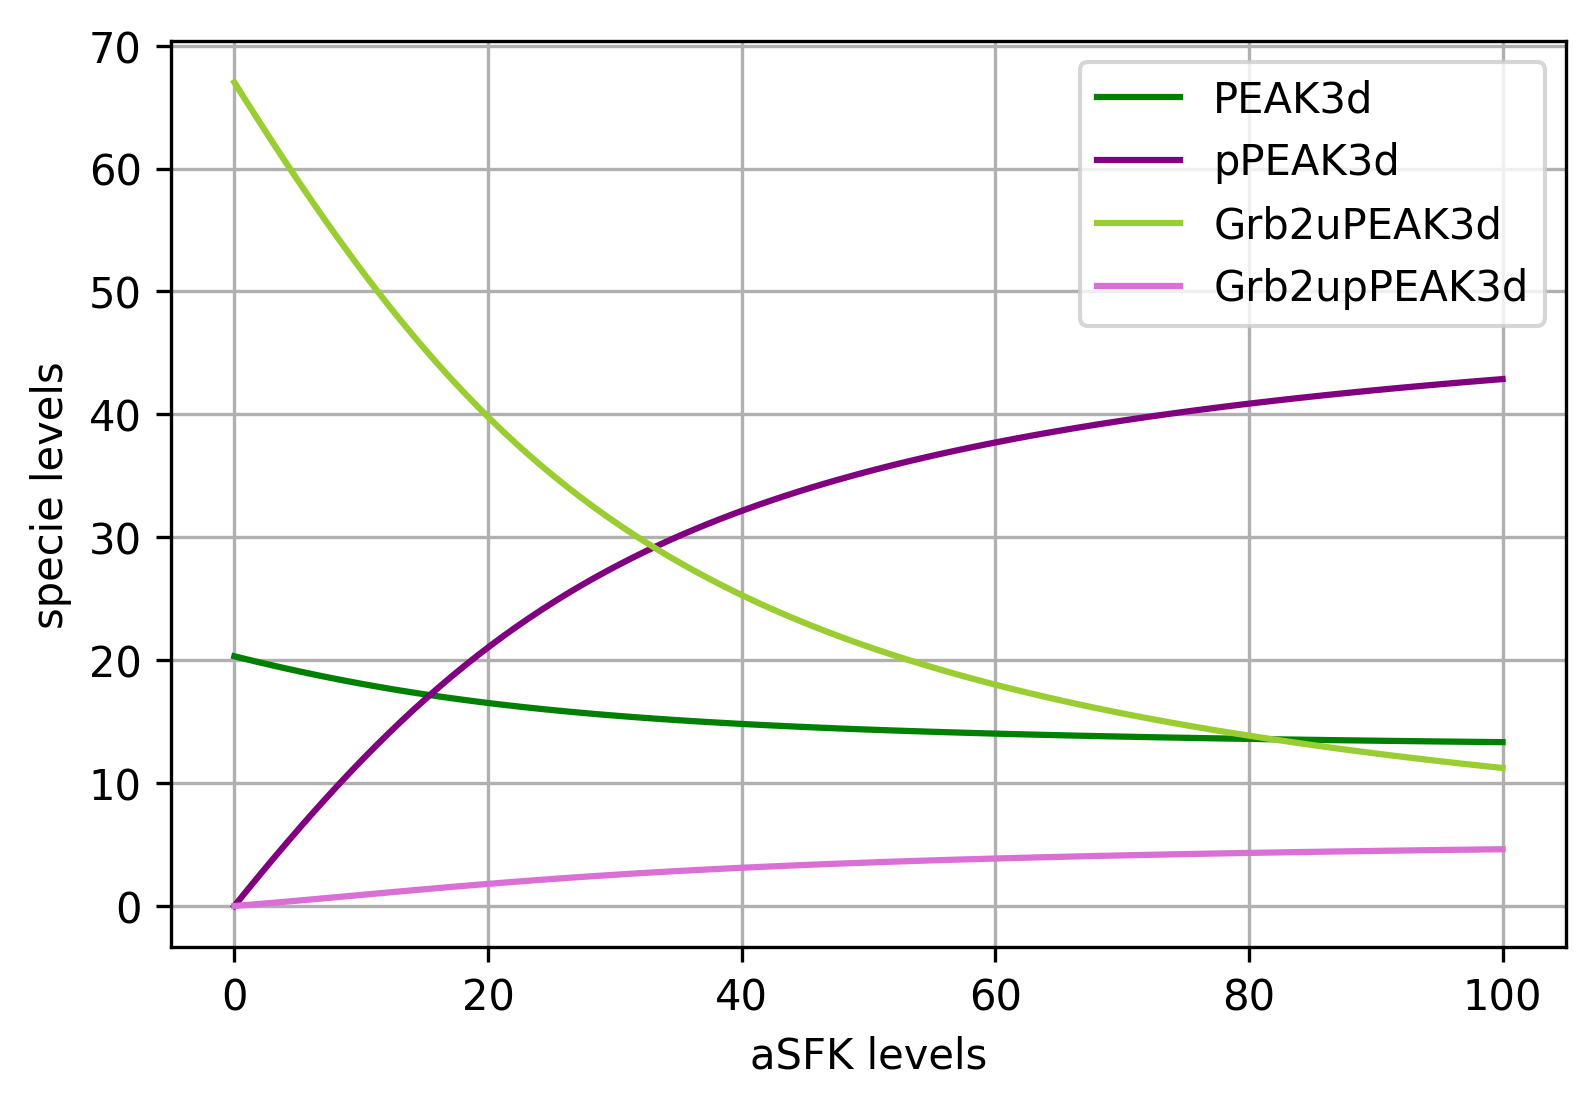

In [21]:
# IO Analysis: aSFK (I) -> all output var.

output_list = [[], [], [], []]
output_var = ['PEAK3d', 'pPEAK3d', 'Grb2uPEAK3d', 'Grb2upPEAK3d']
p_range = np.linspace(0, 100, 100)
input_state = "aSFK"

for p in p_range:
    Module_PEAK3_main.setState(input_state, p)
    Module_PEAK3_main.simulate_beta(200)
    i = 0
    while i < len(output_list):
        o = Module_PEAK3_main.extractStateValues(output_var[i])[-1]
        output_list[i].append(o)
        i += 1

colours = ['green', 'purple', 'yellowgreen', 'orchid']
i = 0
while i < len(output_list):
    plt.plot(p_range, output_list[i], label=output_var[i], c=colours[i])
    i += 1

plt.legend()
plt.grid()
plt.xlabel('{i} levels'.format(i=input_state))
# plt.xscale('log')
plt.ylabel('specie levels')
plt.savefig("mpl-38-main-asfk.png")
plt.show()

Module_PEAK3_main.setState(input_state, 100) # reset 


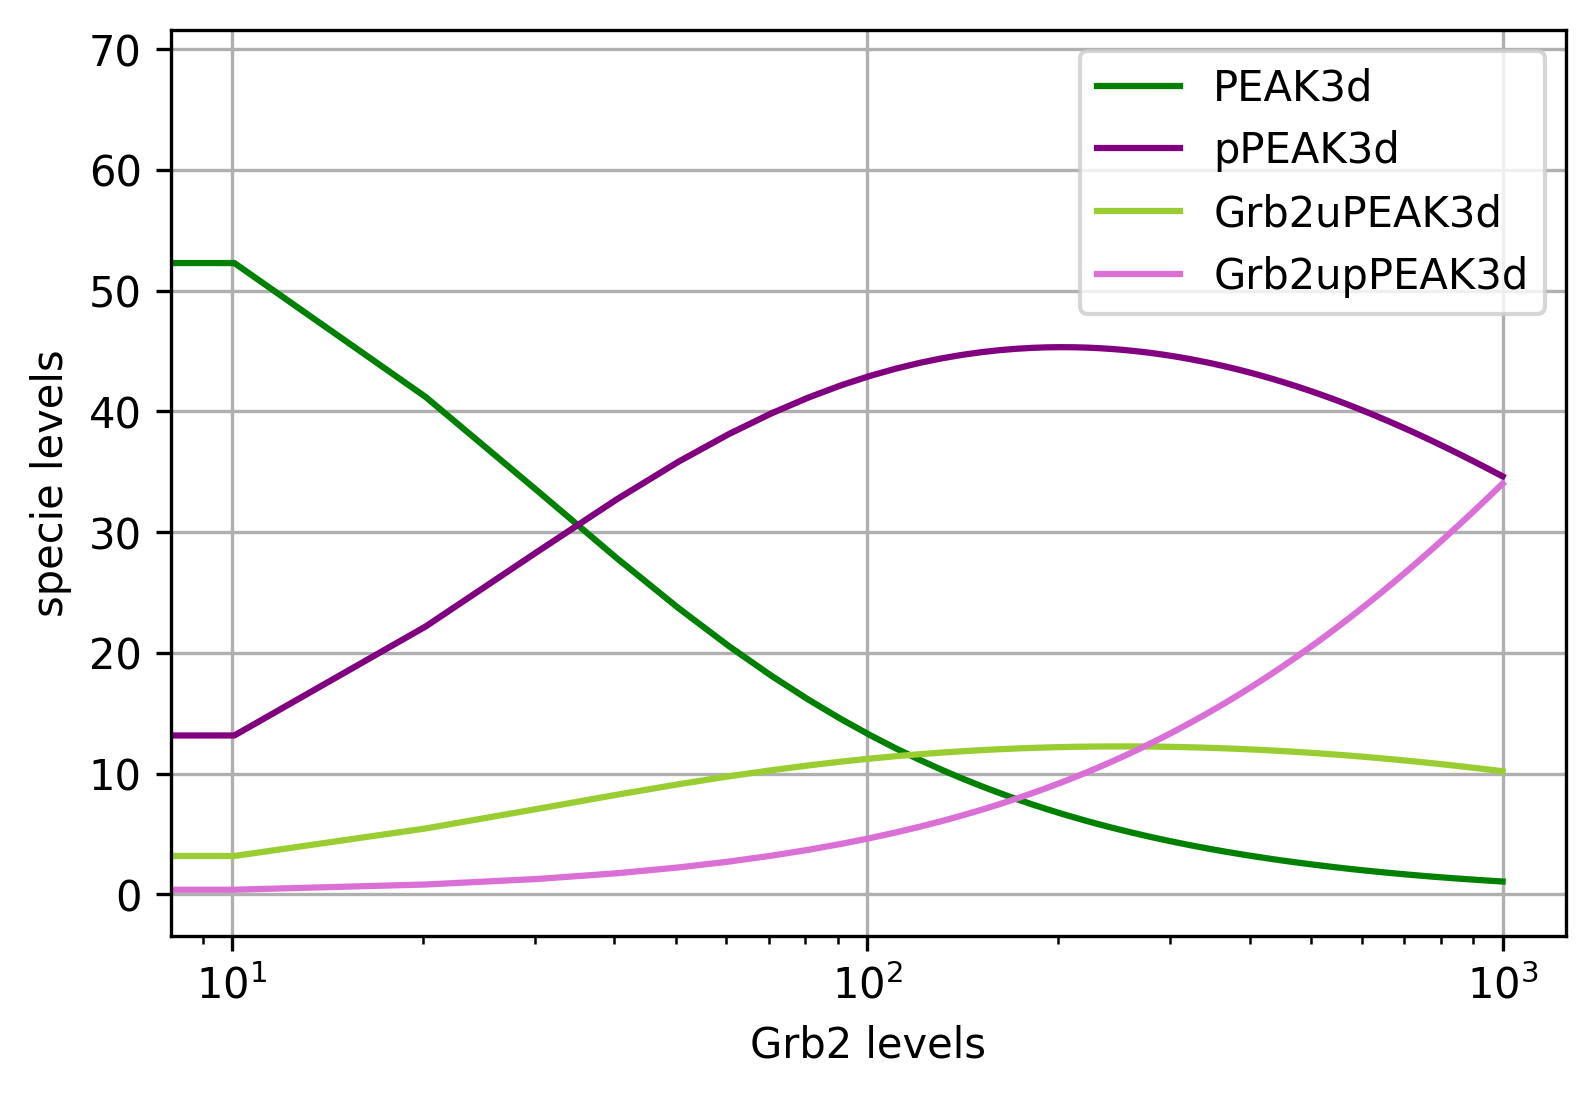

In [22]:
# IO Analysis: Grb2 (I) -> all output var.

output_list = [[], [], [], []]
output_var = ['PEAK3d', 'pPEAK3d', 'Grb2uPEAK3d', 'Grb2upPEAK3d']
p_range = np.linspace(0, 1000, 100)
input_state = "Grb2"

for p in p_range:
    Module_PEAK3_main.setState(input_state, p)
    Module_PEAK3_main.simulate_beta(200)
    i = 0
    while i < len(output_list):
        o = Module_PEAK3_main.extractStateValues(output_var[i])[-1]
        output_list[i].append(o)
        i += 1

colours = ['green', 'purple', 'yellowgreen', 'orchid']
i = 0
while i < len(output_list):
    plt.plot(p_range, output_list[i], label=output_var[i], c=colours[i])
    i += 1

plt.legend()
plt.grid()
plt.xlabel('{i} levels'.format(i=input_state))
plt.xscale('log')
plt.ylabel('specie levels')
plt.savefig('mpl-38-main-grb2.png')
plt.show()

Module_PEAK3_main.setState(input_state, 100)


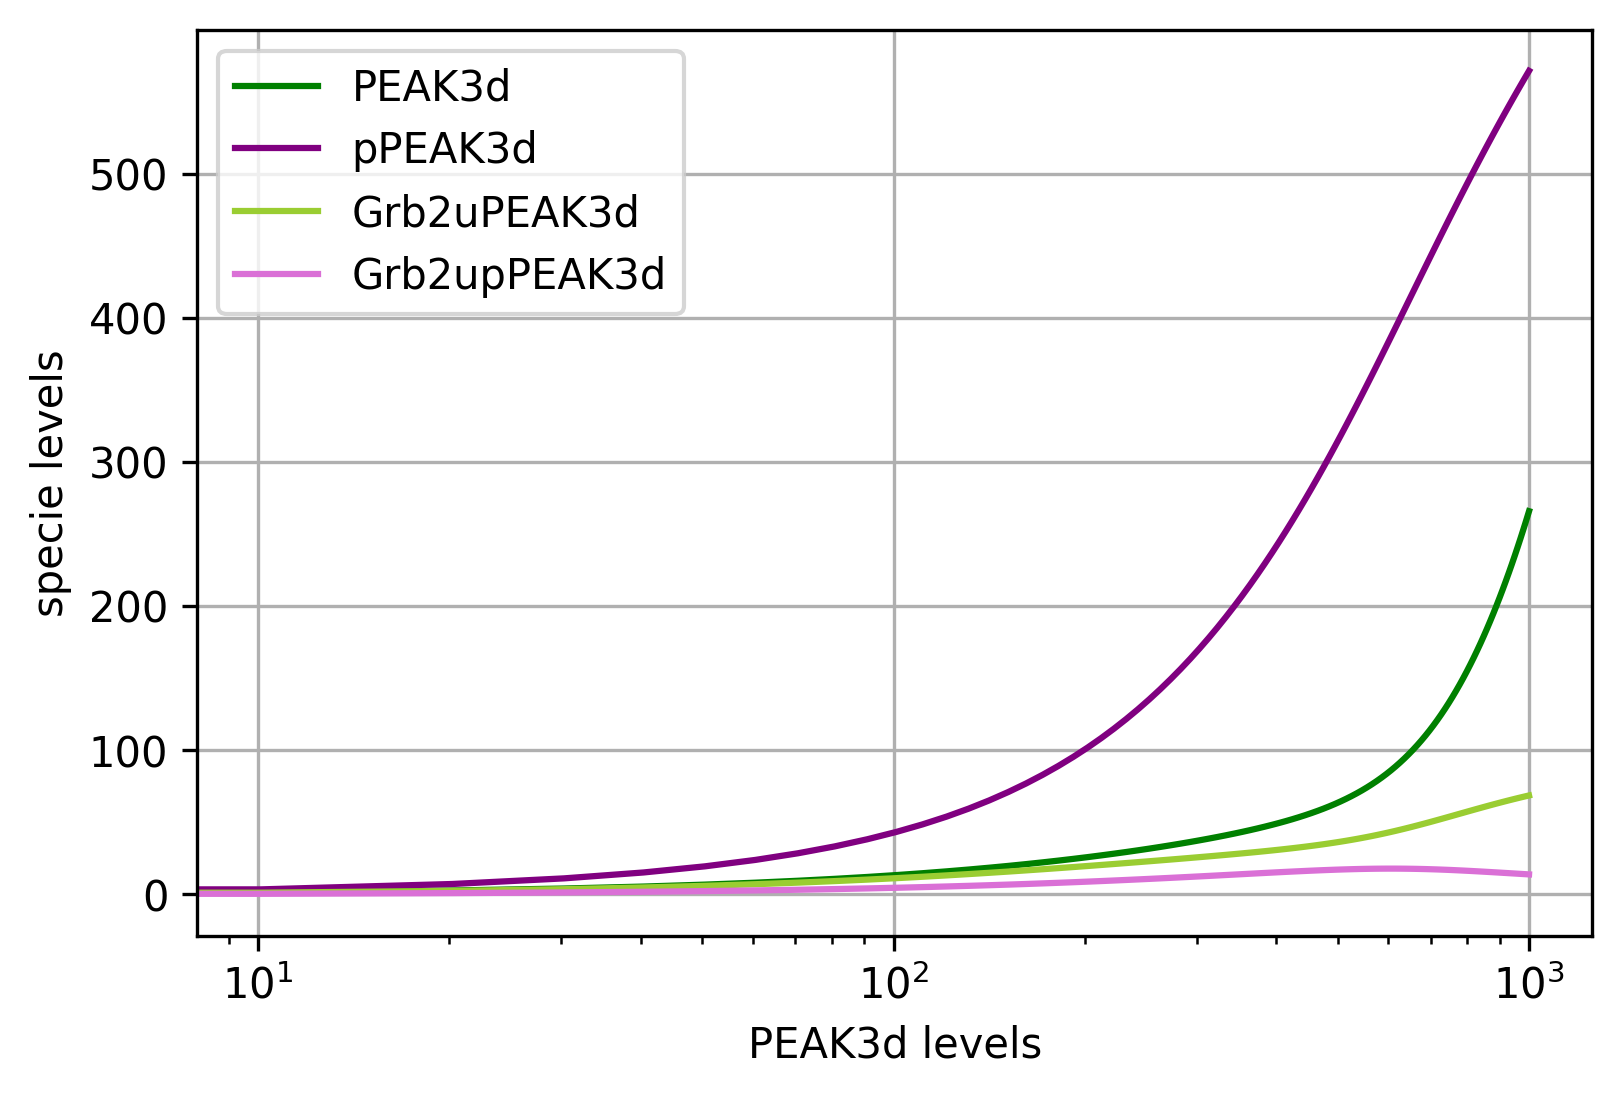

In [23]:
# IO Analysis: PEAK3d (I) -> all output var.

output_list = [[], [], [], []]
output_var = ['PEAK3d', 'pPEAK3d', 'Grb2uPEAK3d', 'Grb2upPEAK3d']
p_range = np.linspace(0, 1000, 100)
input_state = "PEAK3d"

for p in p_range:
    Module_PEAK3_main.setState(input_state, p)
    Module_PEAK3_main.simulate_beta(200)
    i = 0
    while i < len(output_list):
        o = Module_PEAK3_main.extractStateValues(output_var[i])[-1]
        output_list[i].append(o)
        i += 1

colours = ['green', 'purple', 'yellowgreen', 'orchid']
i = 0
while i < len(output_list):
    plt.plot(p_range, output_list[i], label=output_var[i], c=colours[i])
    i += 1

plt.legend()
plt.grid()
plt.xlabel('{i} levels'.format(i=input_state))
plt.xscale('log')
plt.ylabel('specie levels')
plt.savefig("mpl-38-main-peak3d.png")
plt.show()

Module_PEAK3_main.setState(input_state, 100)

# there are some interesting behaviour with Grb2upPEAK3d


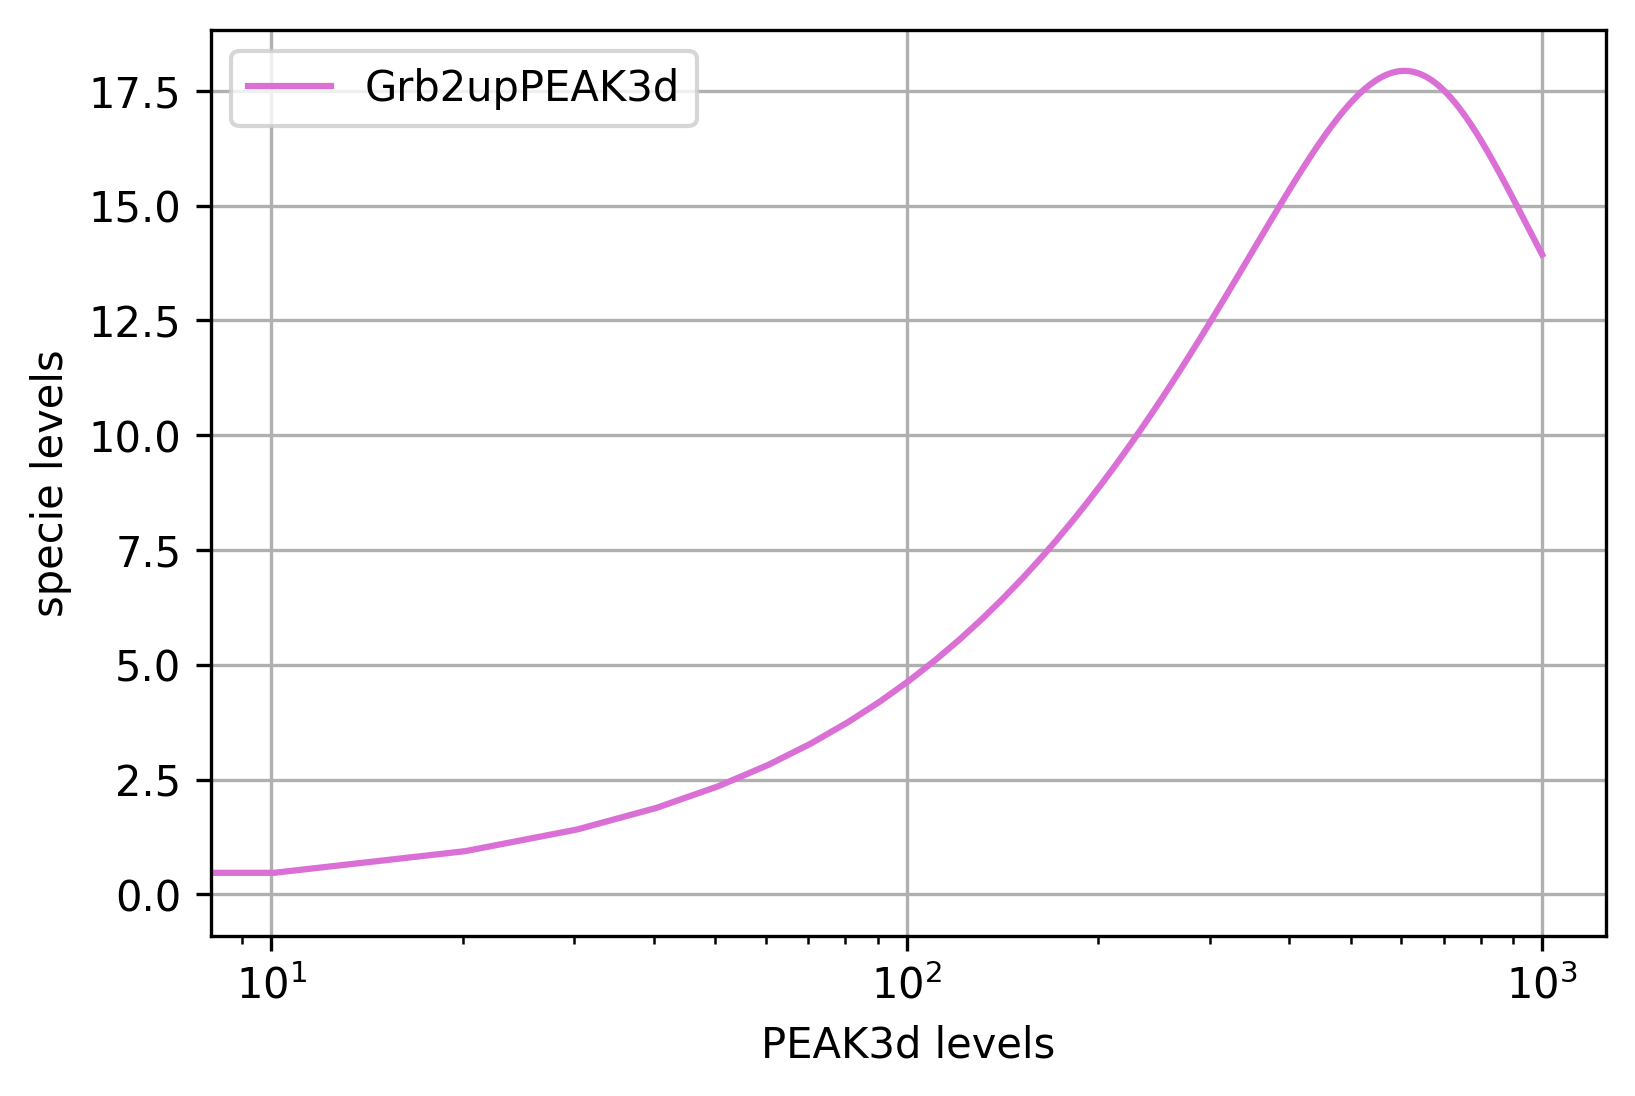

In [24]:
# Following from the code block above, what about plotting only Grb2upPEAK3d?

output_list = [[]]
output_var = ['Grb2upPEAK3d']
p_range = np.linspace(0, 1000, 100)
input_state = "PEAK3d"

for p in p_range:
    Module_PEAK3_main.setState(input_state, p)
    Module_PEAK3_main.simulate_beta(200)
    i = 0
    while i < len(output_list):
        o = Module_PEAK3_main.extractStateValues(output_var[i])[-1]
        output_list[i].append(o)
        i += 1

i = 0
while i < len(output_list):
    plt.plot(p_range, output_list[i], label=output_var[i], c='orchid')
    i += 1

plt.legend()
plt.grid()
plt.xlabel('{i} levels'.format(i=input_state))
plt.xscale('log')
plt.ylabel('specie levels')
plt.savefig('mpl-38-main-peak3d-zoomed.png')
plt.show()

Module_PEAK3_main.setState(input_state, 100)


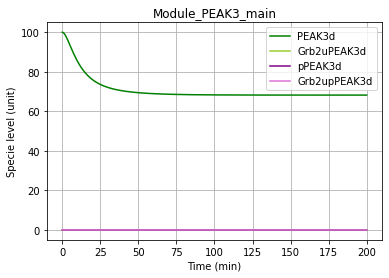

In [30]:
# demonstrating that Grb2 KO still abolishes phosphorylation of PEAK3

Module_PEAK3_main.setState('Grb2', 0) 

Module_PEAK3_main.simulate_beta(200)
Module_PEAK3_main.plotOnly(only_print=peak3_vars, colours = ['green', 'yellowgreen', 'purple','orchid'])

Module_PEAK3_main.setState('Grb2', 100) # reset


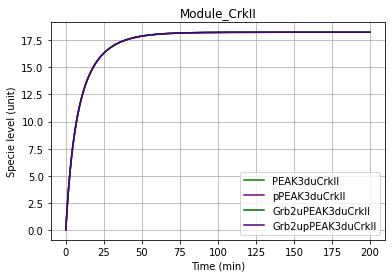

In [31]:
def downstreamModule(target):

    Module_temp = OdeModel('Module_{t}'.format(t=target))

    peak3_vars = ['PEAK3d', 'pPEAK3d', 'Grb2uPEAK3d', 'Grb2upPEAK3d']
    for p in peak3_vars:
        Module_temp.addReaction(re.MassAction(p, target))

    Module_temp.specieConc(peak3_vars, [25, 25, 25, 25])
    # ^ changing peak3 var conc. changes not only the corresponding peak3 var. bound ASAP1
    # it also changes other PEAK3 var. bound ASAP1 conc.
    # ASAP1 uniformly changes all bound ASAP1 species
    Module_temp.setState(target, 100)
    return Module_temp

Module_CrkII = downstreamModule('CrkII')

ignore = peak3_vars.copy()
ignore.append('CrkII')
Module_CrkII.simulate_beta(200)
Module_CrkII.plot(ignore_list=ignore, colours=['green', 'purple', 'darkgreen', 'indigo'])



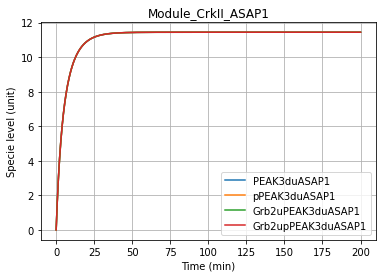

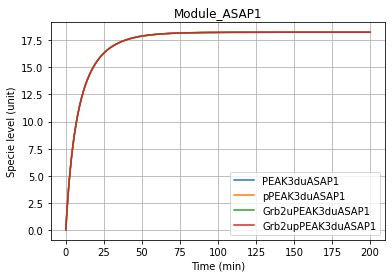

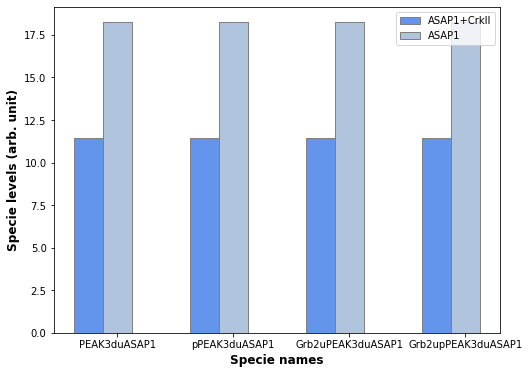

In [61]:
Module_CrkII_c = downstreamModule('CrkII') # creates identical CrkII module
Module_ASAP1_c = downstreamModule('ASAP1') # creates identical ASAP1 module

Module_CrkII_ASAP1 = Module_CrkII_c.combine(Module_ASAP1_c, 'Module_CrkII_ASAP1')

peak3_vars_ASAP1 = ['PEAK3duASAP1', 'pPEAK3duASAP1', 'Grb2uPEAK3duASAP1', 'Grb2upPEAK3duASAP1']
peak3_vars_CrkII = ['PEAK3duCrkII', 'pPEAK3duCrkII', 'Grb2uPEAK3duCrkII', 'Grb2upPEAK3duCrkII']

Module_CrkII_ASAP1.simulate_beta(200)
Module_CrkII_ASAP1.plotOnly(only_print=peak3_vars_ASAP1)

Module_ASAP1.simulate_beta(200)
Module_ASAP1.plotOnly(only_print=peak3_vars_ASAP1)

# due to the combination of ASAP1 and CrkII modules, the peak vars. are shared 
# and therefore results in less ASAP1 bound PEAK3 vars in total

# TODO: bar chart displays this better


ca_ = []
a_ = []

for p in peak3_vars_ASAP1:
    ca = Module_CrkII_ASAP1.extractStateValues(p)[-1]
    ca_.append(ca)
    a = Module_ASAP1.extractStateValues(p)[-1]
    a_.append(a)

# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize=(8, 6))

# Set position of bar on X axis
br1 = np.arange(len(ca_))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(br1, ca_, color='cornflowerblue', width=barWidth,
        edgecolor='grey', label='ASAP1+CrkII')
plt.bar(br2, a_, color='lightsteelblue', width=barWidth,
        edgecolor='grey', label='ASAP1')

# Adding Xticks
plt.xlabel('Specie names', fontweight='bold', fontsize=12)
plt.ylabel('Specie levels (arb. unit)', fontweight='bold', fontsize=12)
plt.xticks([r + barWidth for r in range(len(ca_))],
           peak3_vars_ASAP1)

plt.legend()
plt.show()



name: Module_CrkII_ASAP1_1 | forward specie(s): PEAK3d CrkII | backward specie(s): PEAK3duCrkII | type: MassAction
name: Module_CrkII_ASAP1_2 | forward specie(s): pPEAK3d CrkII | backward specie(s): pPEAK3duCrkII | type: MassAction
name: Module_CrkII_ASAP1_3 | forward specie(s): Grb2uPEAK3d CrkII | backward specie(s): Grb2uPEAK3duCrkII | type: MassAction
name: Module_CrkII_ASAP1_4 | forward specie(s): Grb2upPEAK3d CrkII | backward specie(s): Grb2upPEAK3duCrkII | type: MassAction
name: Module_CrkII_ASAP1_5 | forward specie(s): PEAK3d ASAP1 | backward specie(s): PEAK3duASAP1 | type: MassAction
name: Module_CrkII_ASAP1_6 | forward specie(s): pPEAK3d ASAP1 | backward specie(s): pPEAK3duASAP1 | type: MassAction
name: Module_CrkII_ASAP1_7 | forward specie(s): Grb2uPEAK3d ASAP1 | backward specie(s): Grb2uPEAK3duASAP1 | type: MassAction
name: Module_CrkII_ASAP1_8 | forward specie(s): Grb2upPEAK3d ASAP1 | backward specie(s): Grb2upPEAK3duASAP1 | type: MassAction



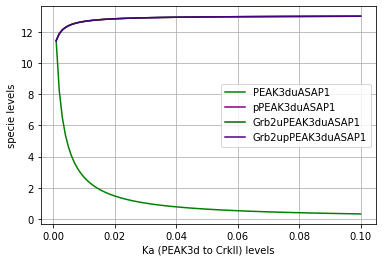

In [34]:
# kinetic constants of CrkII to PEAK3 binding affects ASAP1 to PEAK3 binding

print(Module_CrkII_ASAP1)

output_list = [[], [], [], []]
output_var = peak3_vars_ASAP1
p_range = np.linspace(0.001, 0.1, 100)

rId = 'Module_CrkII_ASAP1_1'
pId = 'ka'
pDefault = 0.001

for p in p_range:
    Module_CrkII_ASAP1.setParam(rId, pId, p) # ka for CrkII to PEAK3d
    Module_CrkII_ASAP1.simulate_beta(200)
    i = 0
    while i < len(output_list):
        o = Module_CrkII_ASAP1.extractStateValues(output_var[i])[-1]
        output_list[i].append(o)
        i += 1

colours = ['green', 'purple', 'darkgreen', 'indigo']
i = 0
while i < len(output_list):
    plt.plot(p_range, output_list[i], label=output_var[i], c=colours[i])
    i += 1

plt.legend()
plt.grid()
plt.xlabel('{i} levels'.format(i='Ka (PEAK3d to CrkII)')) # remember to change figure labels!d
# plt.xscale('log')
plt.ylabel('specie levels')
plt.savefig('mpl-39-ka.png')
plt.show()

Module_CrkII_ASAP1.setParam(rId, pId, pDefault) # reset
